In [ ]:
########################################
## COLAB CLONE REPOSITORY FROM GITHUB ##
########################################

## Note: only run this section if you are running the code in Google Colab and want to clone the repository from GitHub

## Clone GitHub repository and change work directory
!git clone https://github.com/willembonnaffe/mbipm
%cd mbipm

#
###

In [ ]:
##############################
## COLAB MOUNT GOOGLE DRIVE ##
##############################

## Note: only run this section if you are running the code in Google Colab and want to mount Google Drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/my-files/projects/yem # Change path to match local repository

#
###

In [1]:
##############
## INITIATE ##
##############

## Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import yaml
import os

## Import modules
from f_YEM_V1_14_2025_10_10 import pdf
from f_YEM_V1_14_2025_10_10 import f_normal
from f_YEM_V1_14_2025_10_10 import YellowstoneEcosystemModel
from f_YEM_V1_14_2025_10_10 import plot_model

## Set the device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
device = "cpu" # Force cpu for now
print(device)

## Figure parameters
plt.rcParams['figure.dpi'] = 100
FIGSIZE = (6,4)
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'axes.facecolor':'whitesmoke'}
sns.set_theme(style="ticks", rc=custom_params)

## Font
PAPER_FORMATTING = False
if PAPER_FORMATTING == True:
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.rcParams['font.size'] = 14
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.rm'] = 'Times New Roman'
    plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
    plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

#
###

cpu


In [63]:
####################
## INITIATE MODEL ##
####################

## Model
model = YellowstoneEcosystemModel('parameters-apriori-V1-14-2025-10-10.yaml')

## Load the YAML file
with open('initial-conditions-apriori-V1-14-2025-10-10.yaml', 'r') as file:
    initial_conditions = yaml.safe_load(file)

## Convert to tensors
Dt0 = torch.tensor(initial_conditions['Dt0'], dtype=torch.float64)
Bt0 = torch.tensor(initial_conditions['Bt0'], dtype=torch.float64)
Pt0 = torch.tensor(initial_conditions['Pt0'], dtype=torch.float64)
Gt0 = torch.tensor(initial_conditions['Gt0'], dtype=torch.float64)
NNt0 = torch.tensor(initial_conditions['NNt0'], dtype=torch.float64)
NNNzt0 = torch.tensor(initial_conditions['NNNzt0'], dtype=torch.float64)

## Load settings
with open('settings-apriori-V1-14-2025-10-10.yaml', 'r') as file:
    settings = yaml.safe_load(file)

## Convert to tensor
zzmax = torch.tensor(settings['zzmax'], dtype=torch.float64)
zzz_len = settings['zzz_len']

#
###

0.50s


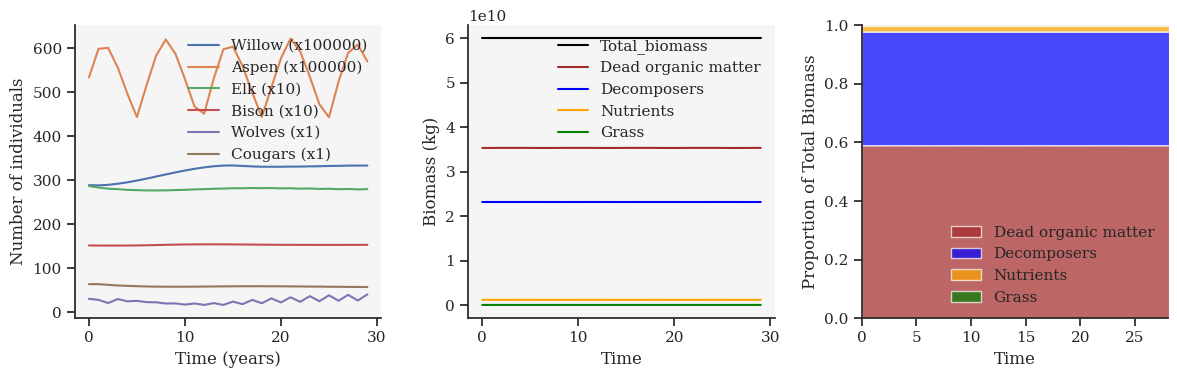

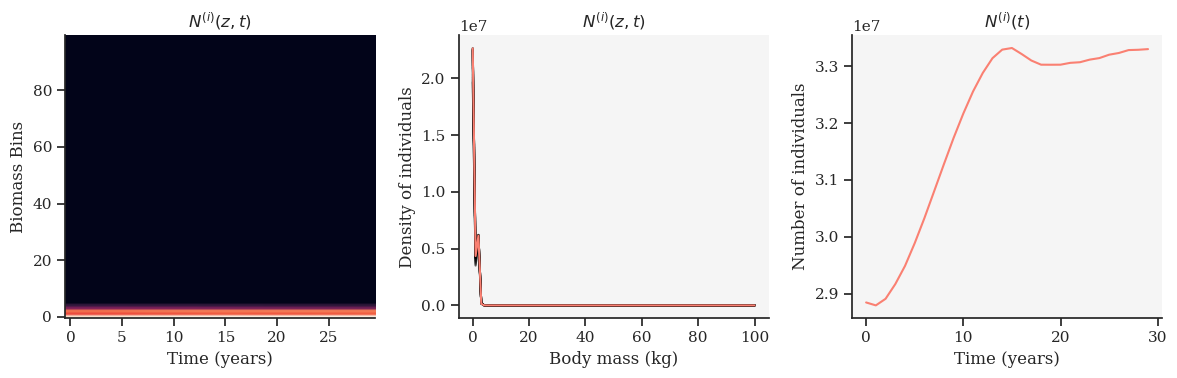

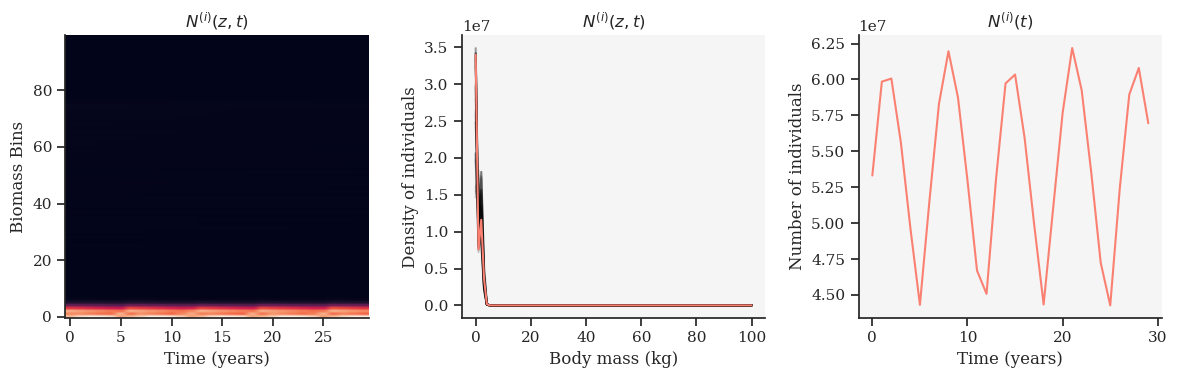

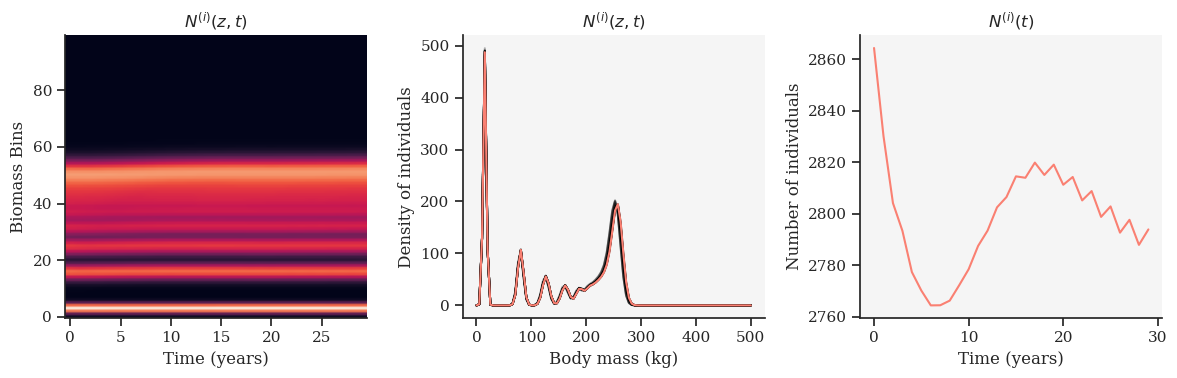

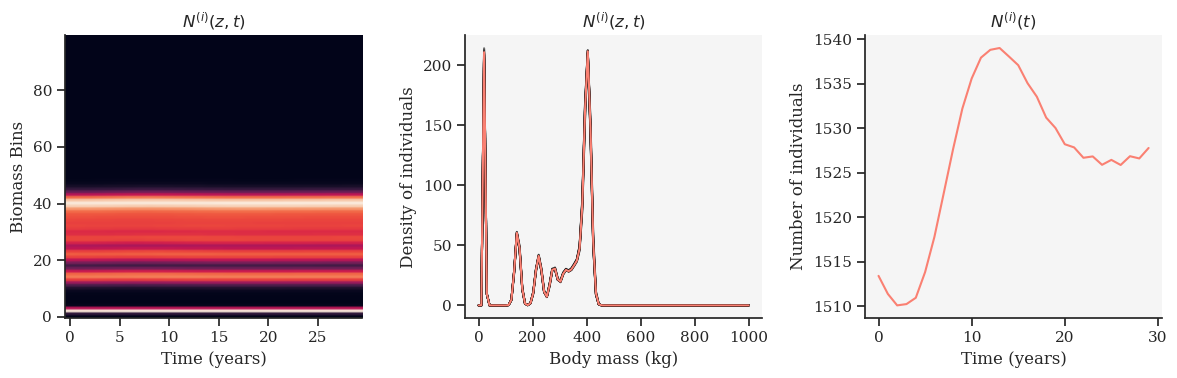

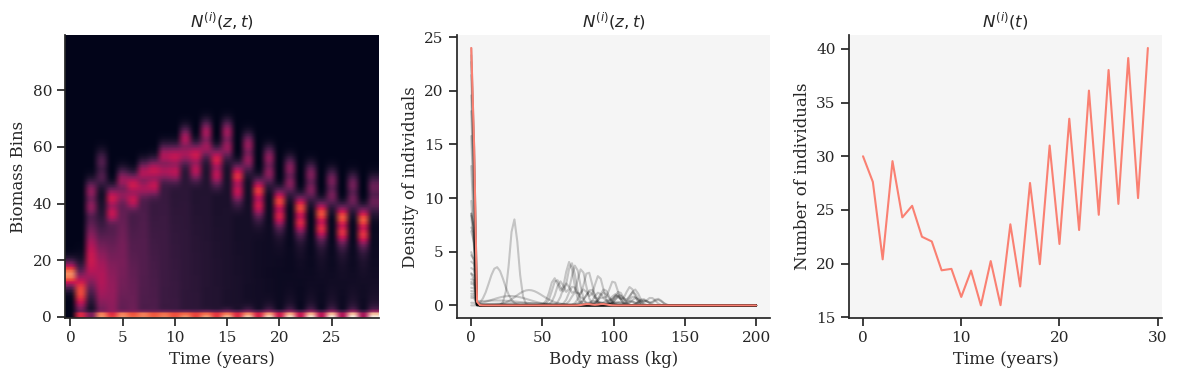

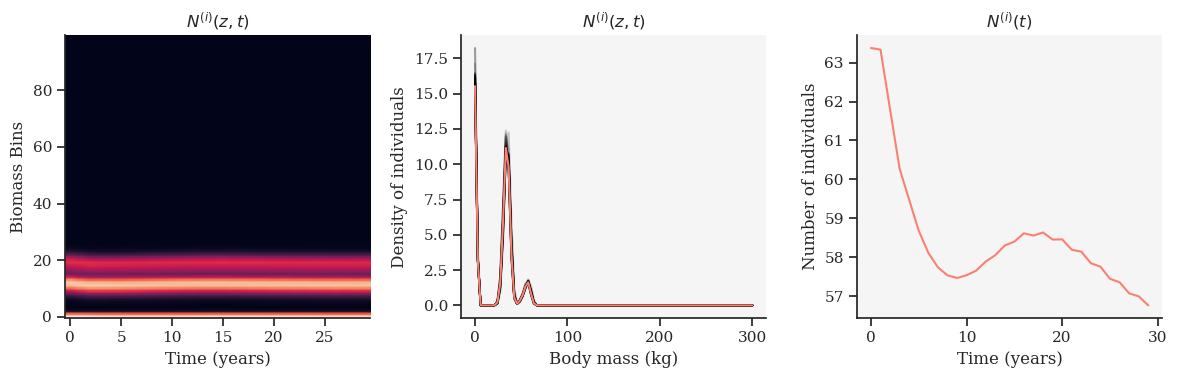

In [64]:
###############
## RUN MODEL ##
###############

## Initiate parameters
t_max = 29

## Period 1
t0 = time.time()
predictions = model.simulate(t_max=t_max,
                             Dt = Dt0,
                             Bt = Bt0,
                             Pt = Pt0,
                             Gt = Gt0,
                             NNt = NNt0,
                             NNNzt = NNNzt0,
                             zzmax = zzmax,
                             zzz_len = zzz_len
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions
tf = time.time()
print(f"{tf-t0:.2f}s")

## Visualise
plot_model(predictions)

#
###

In [65]:
#################################
## LOAD TIME SERIES AND FORMAT ##
#################################

import pandas as pd
import torch

## Load the dataset
df = pd.read_csv("A1-outputs/A1-tab-all-time-series.csv")

## Drop non-numeric/time columns
time_series_df = df.drop(columns=['time_step', 'year'])

## Convert to numeric
time_series_df = time_series_df.apply(pd.to_numeric, errors='coerce').astype('float64')

## Convert DataFrame to a NumPy array preserving missing values as np.nan
time_series_np = time_series_df.to_numpy()

## Convert to torch tensor with float64 precision
time_series_tensor = torch.tensor(time_series_np, dtype=torch.float64)[:,3:7]

print(time_series_tensor.shape) # Should be (num_timesteps, num_variables)

#
###

torch.Size([30, 4])


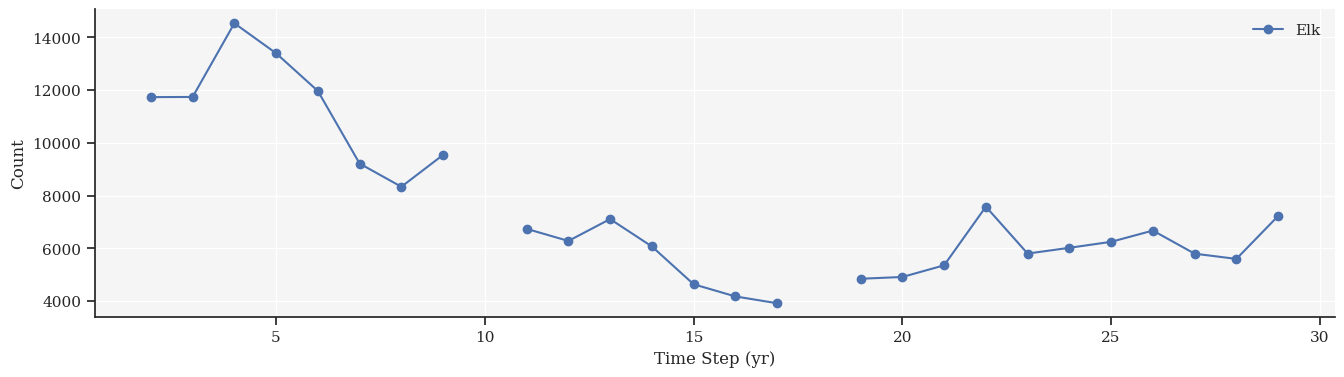

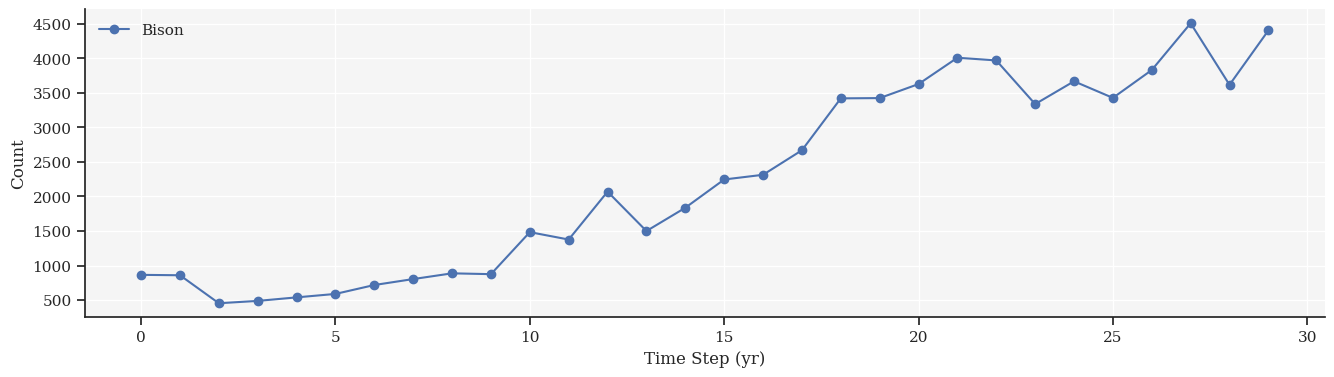

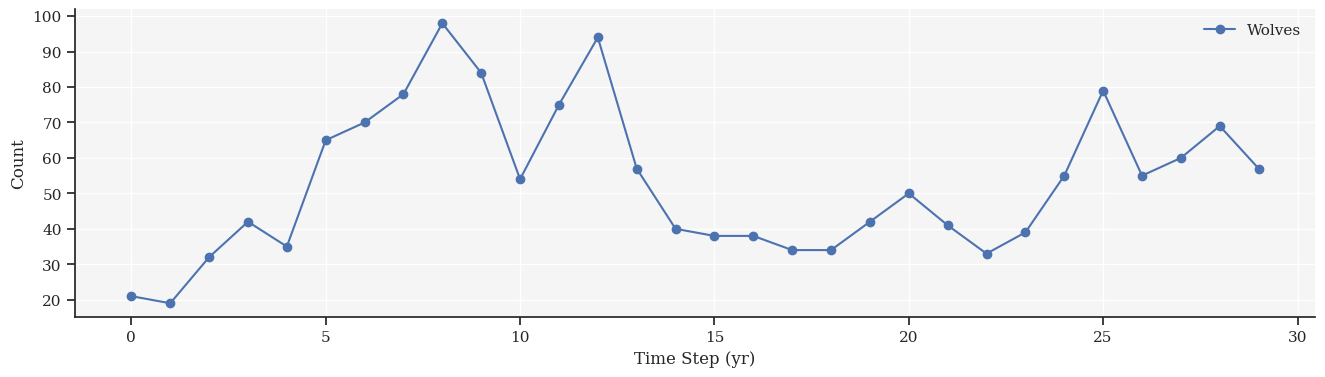

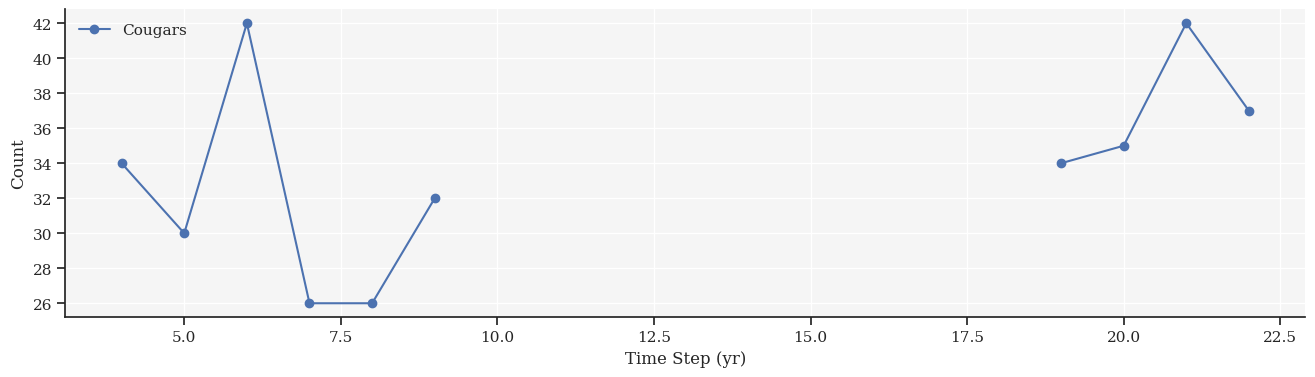

In [66]:
###################
## VISUALISATION ##
###################

def plot_time_series(time_series_tensor_):
    """    
    """     
    llabels = ['Elk', 'Bison', 'Wolves', 'Cougars']
    k = 0
    for i in range(4):        
        plt.figure(figsize=(16,4))
        plt.plot(time_series_tensor_[:, i], 'o-', label=llabels[k])
        plt.xlabel('Time Step (yr)')
        plt.ylabel('Count')
        plt.legend(frameon=False)
        plt.grid(color='white')        
        plt.show()
        plt.close()
        k += 1

## Plot
plot_time_series(time_series_tensor)

#
###

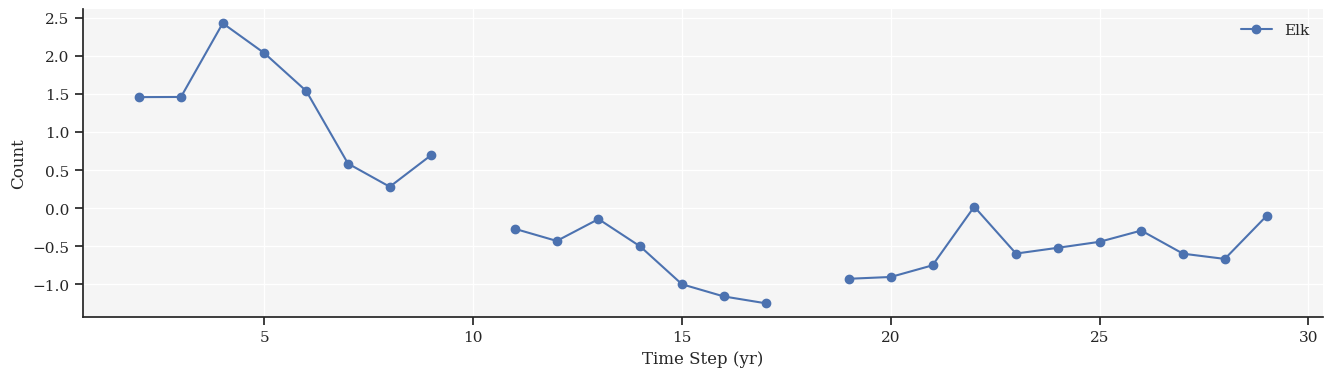

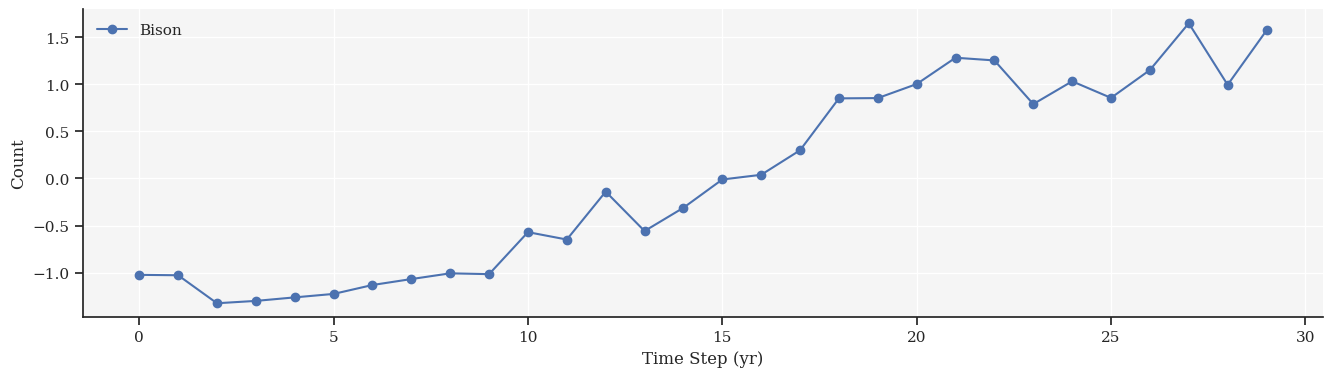

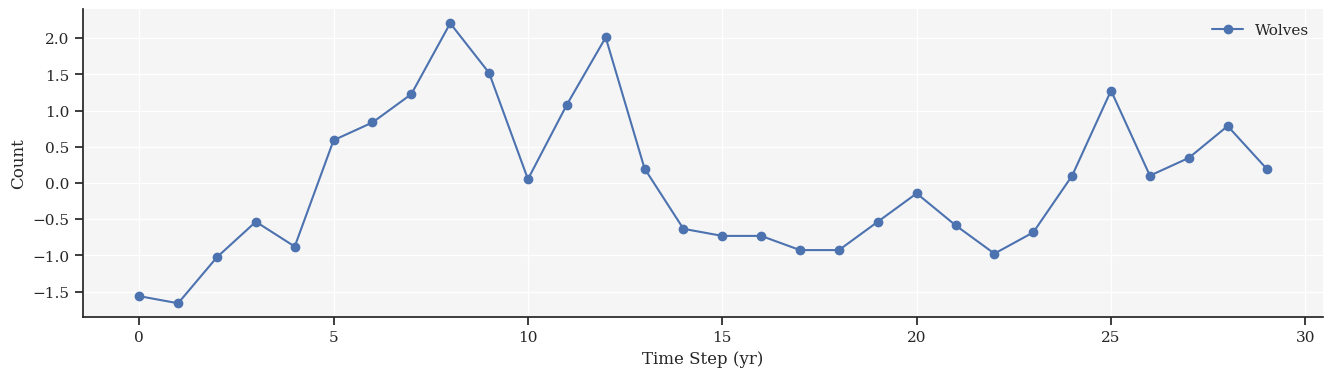

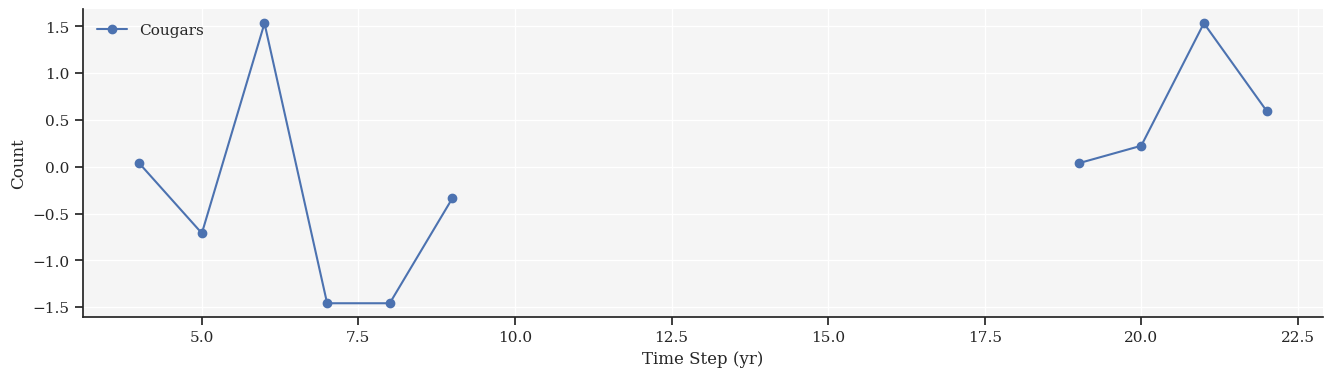

In [67]:
#####################
## STANDARDISATION ##
#####################

def compute_nan_mean_std(x, dim=None, keepdim=False, eps=1e-8):
    mask = ~torch.isnan(x)
    count = mask.sum(dim=dim, keepdim=True)

    x_masked = torch.where(mask, x, torch.tensor(0.0, dtype=x.dtype, device=x.device))
    mean = x_masked.sum(dim=dim, keepdim=True) / count

    var = ((torch.where(mask, x - mean, torch.tensor(0.0, dtype=x.dtype, device=x.device))) ** 2).sum(dim=dim, keepdim=True) / count
    std = torch.sqrt(var + eps)

    if not keepdim and dim is not None:
        mean = mean.squeeze(dim)
        std = std.squeeze(dim)

    return mean, std

def apply_standardization(x, mean, std):
    z = (x - mean) / std
    z = torch.where(torch.isnan(x), x, z)  # Preserve original NaNs
    return z

def reverse_standardization(z, mean, std):
    x = z * std + mean
    x = torch.where(torch.isnan(z), z, x)  # Preserve original NaNs
    return x

MEAN, STD = compute_nan_mean_std(time_series_tensor, 0)
time_series_tensor_standardised = apply_standardization(time_series_tensor, MEAN, STD)

## Check
plot_time_series(time_series_tensor_standardised)
# plt.plot(time_series_tensor_standardised)
# plt.yscale('log')
# plt.show()

#
###

In [68]:
########################
## FORMAT PREDICTIONS ##
########################

def format_predicted_time_series(predictions):
    zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions        
    time_series_tensor_predicted = NNNt[:,2:6]
    return time_series_tensor_predicted

## Check
time_series_tensor_predicted = format_predicted_time_series(predictions)
print(time_series_tensor_predicted.shape)

#
###

torch.Size([30, 4])


In [15]:
####################
## SIMULATED DATA ##
####################

## For debugging
# time_series_tensor = time_series_tensor_predicted.clone()

#
###

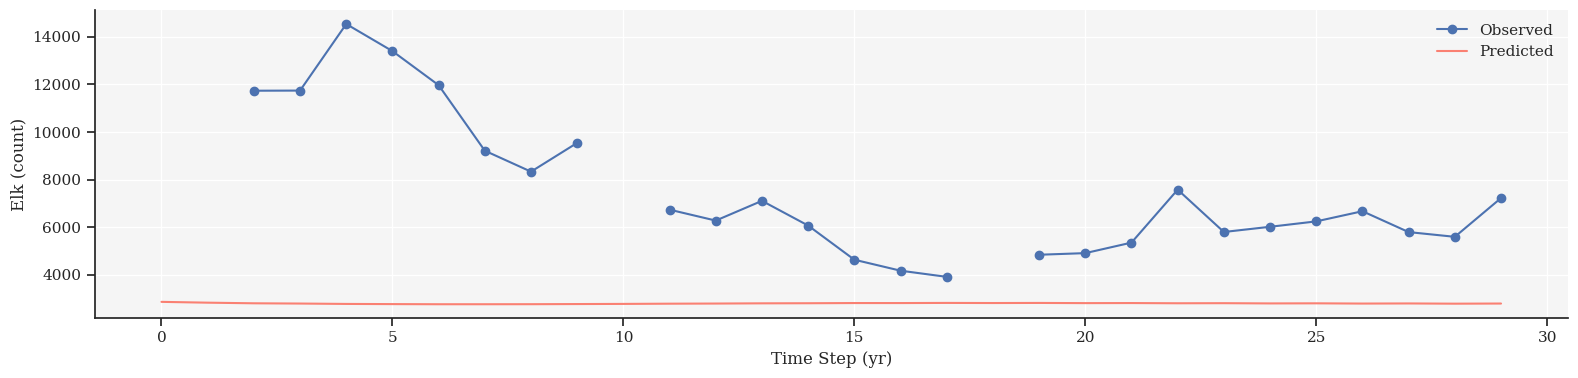

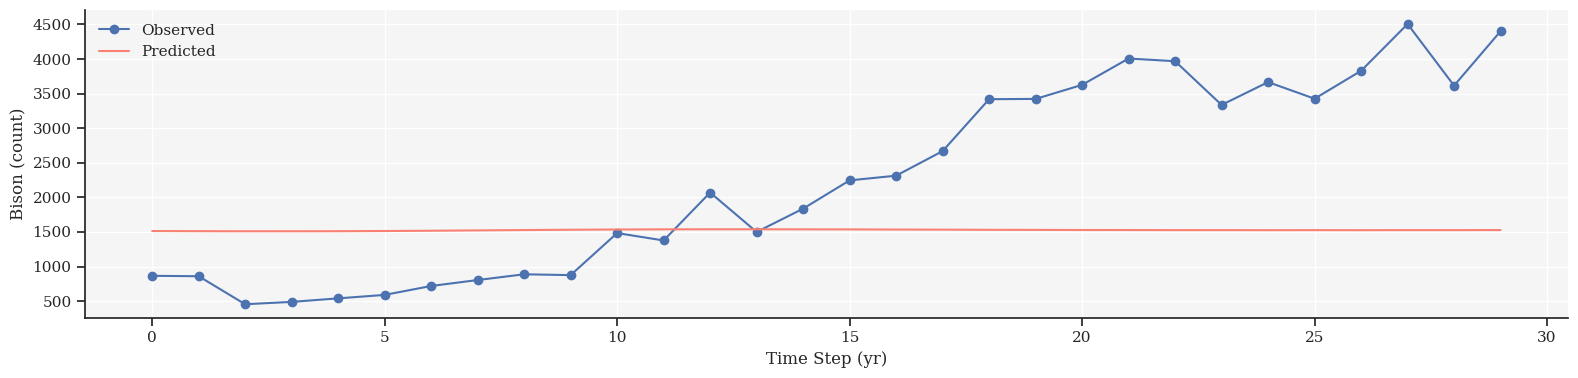

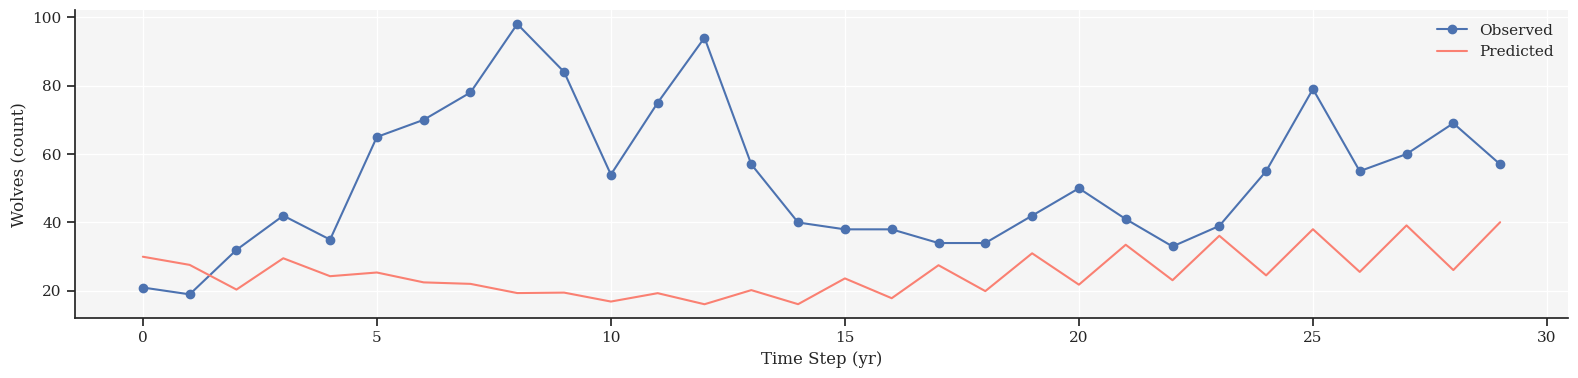

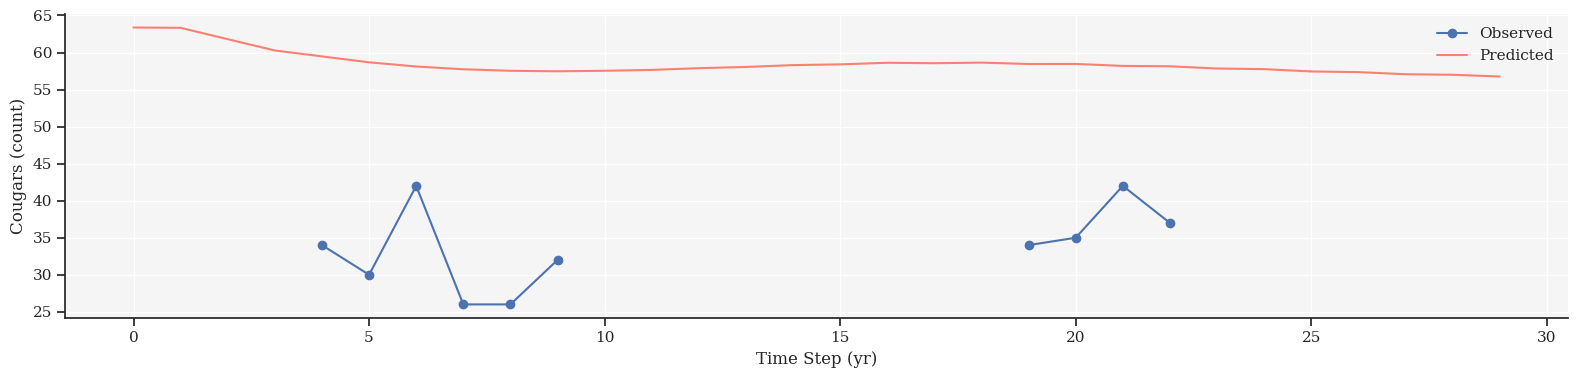

In [69]:
###################
## VISUALISATION ##
###################

def plot_fit_subplots(time_series_tensor, time_series_tensor_predicted, log=True):
    """    
    """     
    ccolors = ['brown', 'orange', 'grey', 'saddlebrown']
    yylabels = ['Elk (count)', 'Bison (count)', 'Wolves (count)', 'Cougars (count)']
    T, V = time_series_tensor.shape
    x = range(T)    
    for i in range(4):        
        plt.figure(figsize=(16,4))
        plt.plot(time_series_tensor[:, i], 'o-', label='Observed')
        plt.plot(x, time_series_tensor_predicted[:, i], '-', label='Predicted', color='salmon')
        plt.xlabel('Time Step (yr)')
        plt.ylabel(yylabels[i])
        plt.legend(frameon=False)
        plt.grid(color='white')        
        plt.tight_layout()
        plt.show()
        plt.close()        

## Check function
plot_fit_subplots(time_series_tensor, time_series_tensor_predicted)
    
#
###

torch.Size([6])
torch.Size([6])
torch.Size([6, 100])
0.51s


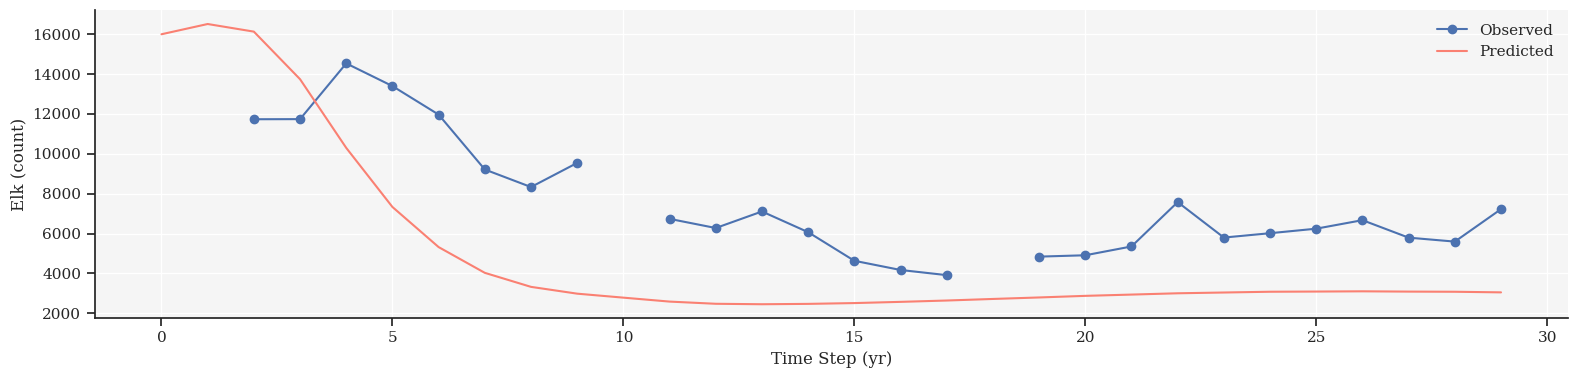

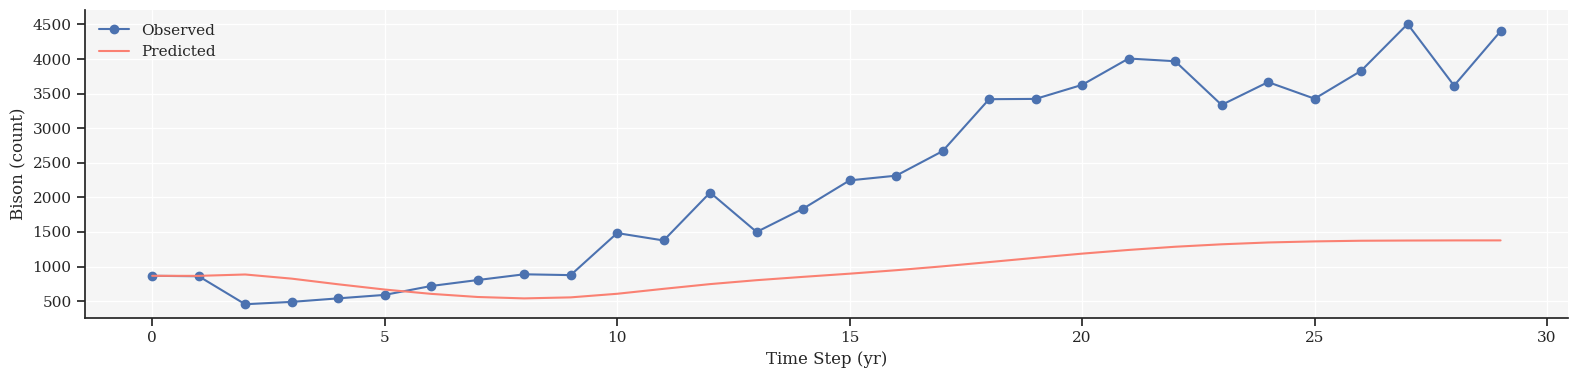

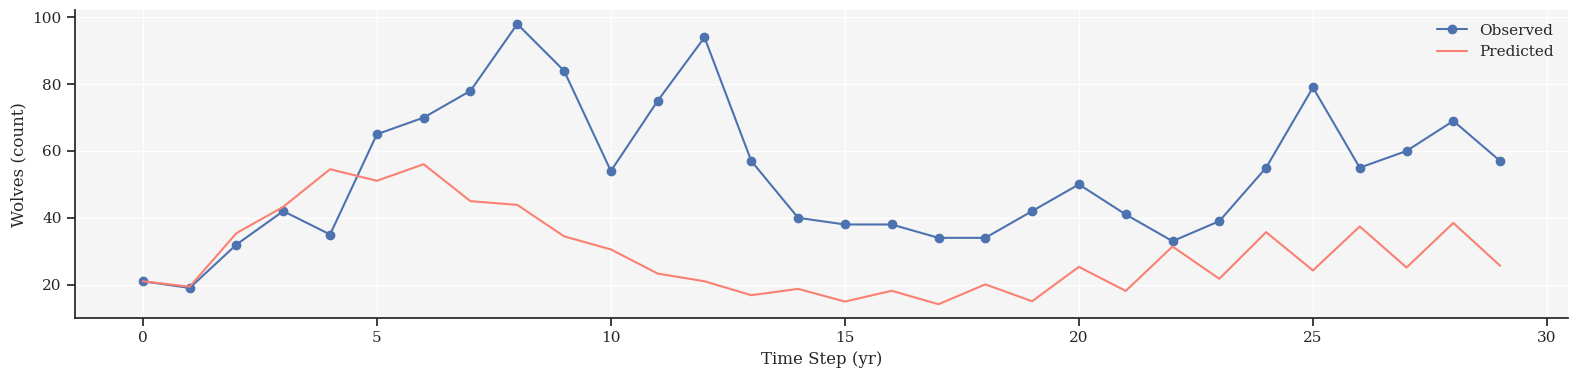

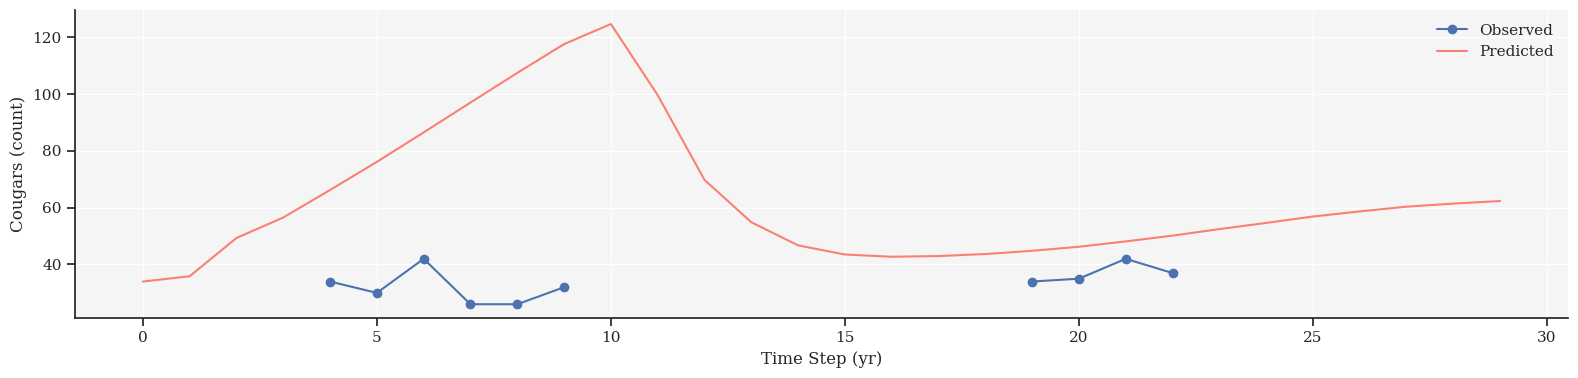

In [70]:
#####################################
## FIND SCALING INITIAL CONDITIONS ##
#####################################

SCALING = [] 
SCALING += [1.0] 
SCALING += [1.0] 
SCALING += [16000/time_series_tensor_predicted[0][0]]
SCALING += [time_series_tensor[0][1]/time_series_tensor_predicted[0][1]]
SCALING += [time_series_tensor[0][2]/time_series_tensor_predicted[0][2]]
SCALING += [time_series_tensor[4][3]/time_series_tensor_predicted[0][3]]
SCALING = torch.tensor(SCALING)
print(SCALING.shape)
print(NNt0.shape)
print(NNNzt0.shape)

## Run
t0 = time.time()
predictions = model.simulate(t_max=t_max,
                             Dt = Dt0,
                             Bt = Bt0,
                             Pt = Pt0,
                             Gt = Gt0,
                             NNt = NNt0 * SCALING,
                             NNNzt = NNNzt0 * SCALING[:,None],
                             zzmax = zzmax,
                             zzz_len = zzz_len
                            )
zzz, tt, DDt, BBt, PPt, GGt, NNNt, NNNNzt, ttotal_biomass = predictions
tf = time.time()
print(f"{tf-t0:.2f}s")

## Check function
plot_fit_subplots(time_series_tensor, format_predicted_time_series(predictions))

#
###

In [71]:
####################################
## SET SCALING INITIAL CONDITIONS ##
####################################

## Initial conditions structured states
print(NNt0)
for i in range(len(NNt0)):
        NNt0[i] = NNt0[i] * SCALING[i]
        NNNzt0[i] = NNNzt0[i] * SCALING[i]
print(NNt0)

#
###

tensor([2.8845e+07, 5.3315e+07, 2.8643e+03, 1.5134e+03, 3.0000e+01, 6.3375e+01])
tensor([2.8845e+07, 5.3315e+07, 1.6000e+04, 8.6600e+02, 2.1000e+01, 3.4000e+01])


In [72]:
############################
## LOAD AND APPLY WRAPPER ##
############################

## Note: global variables should be in capital letters

## Import module
from f_wrapper_YEM_V1_14_2025_10_10 import wrapper_YEM_V1_14
from f_wrapper_YEM_V1_14_2025_10_10 import build_ttheta_index_map, get_name_from_index, get_index_from_name

## Model
model_r = YellowstoneEcosystemModel("parameters-apriori-V1-14-2025-10-10.yaml")
model_p = YellowstoneEcosystemModel("parameters-apriori-V1-14-2025-10-10.yaml")

## Define local wrapper
def wrapper(ttheta, t_max=29):
    return wrapper_YEM_V1_14(ttheta, t_max=t_max, model_r=model_r, model_p=model_p, Dt0=Dt0, Bt0=Bt0, Pt0=Pt0, Gt0=Gt0, NNt0=NNt0, NNNzt0=NNNzt0, zzmax=zzmax, zzz_len=zzz_len)

#
###

125


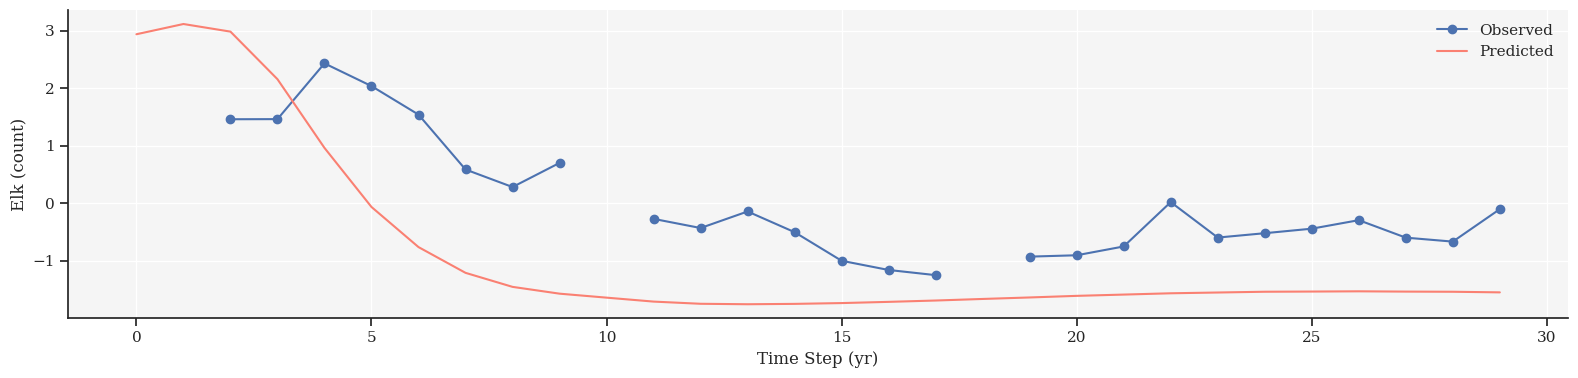

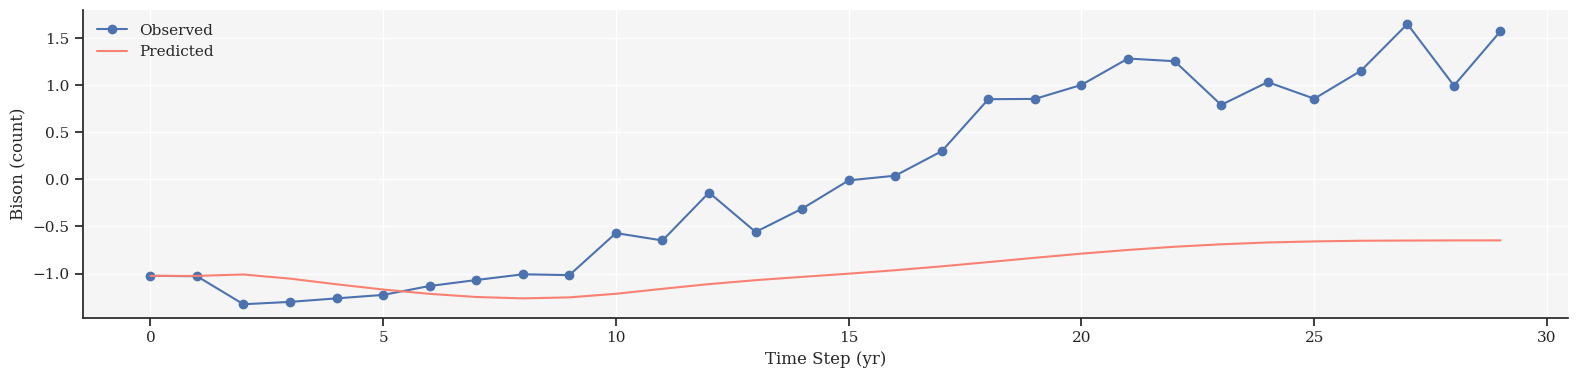

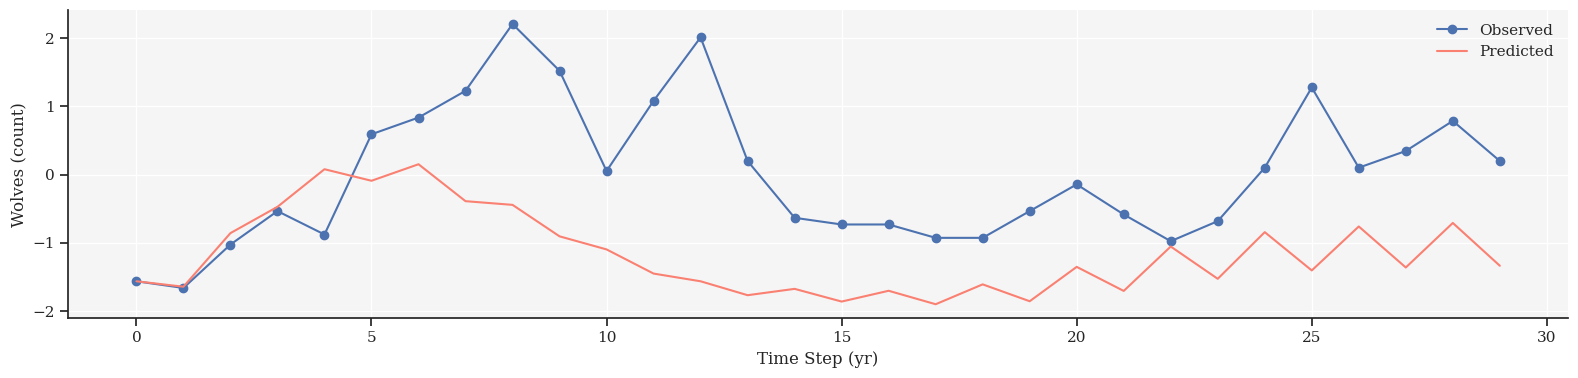

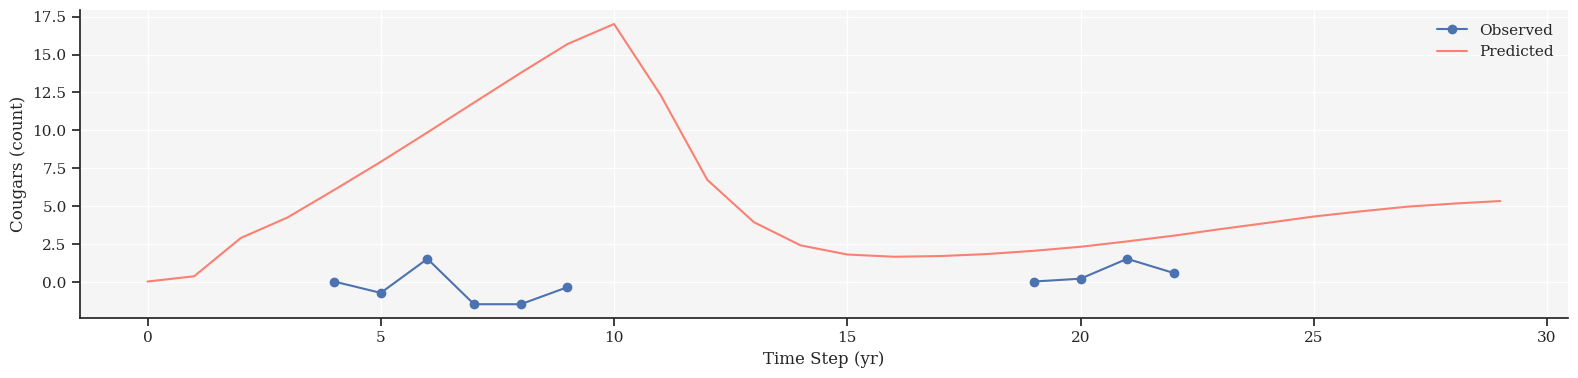

In [73]:
##################
## TEST WRAPPER ##
##################

## Scale parameter vector
num_parameters = len(build_ttheta_index_map(I=6, J=6))
print(num_parameters)
ttheta = torch.ones(num_parameters, dtype=torch.float64)

## Predict
predictions = wrapper(ttheta)
time_series_tensor_predicted = format_predicted_time_series(predictions)

## Standardise
time_series_tensor_predicted_standardised = apply_standardization(format_predicted_time_series(predictions), MEAN, STD)
time_series_tensor_standardised = apply_standardization(time_series_tensor, MEAN, STD)

## Visualise
plot_fit_subplots(time_series_tensor_standardised, time_series_tensor_predicted_standardised, log=False)

#
###

In [74]:
############################
## POSTERIOR DISTRIBUTION ##
############################

## Laplace priors
def log_prior(ttheta, sigma):
    return -1.0/sigma * torch.sum(torch.abs(ttheta - 1.0))

## Gaussian likelihood
def log_likelihood(ttheta):

    ## Predict
    predictions = wrapper(ttheta)
    
    ## Format
    time_series_tensor_predicted = format_predicted_time_series(predictions)

    ## Check for nans
    if torch.sum(torch.isnan(time_series_tensor_predicted))>1:
        log_lik = -float('inf')        
    else:      
        ## Standardise
        time_series_tensor_predicted_standardised = apply_standardization(format_predicted_time_series(predictions), MEAN, STD)            
        
        ## Compute residuals
        res = time_series_tensor_predicted_standardised - time_series_tensor_standardised

        ## Mean of mean squares for each time series            
        log_lik = torch.tensor(0.0, dtype=torch.float64)
        for i in range(res.shape[1]):
            log_lik += - torch.nanmean(res[:,i]**2)

    ## End
    return log_lik

def log_posterior(ttheta, sigma=0.2):
    log_lik = log_likelihood(ttheta)
    log_pri = log_prior(ttheta, sigma)
    log_pos = log_lik + log_pri
    return log_pos, log_lik, log_pri

SIGMA = 1.0
def d_target(ttheta):        
    log_pos, _, _ = log_posterior(ttheta, sigma=SIGMA)
    return log_pos
    
#
###

In [75]:
############
## CHECKS ##
############

## Check priors
ttheta_0 = torch.ones(num_parameters, dtype=torch.float64)
print(log_prior(ttheta_0, .2))

## Check posterior
t0 = time.time()
ttheta_0 = torch.ones(num_parameters, dtype=torch.float64)
print(log_posterior(ttheta_0))
tf = time.time()
print(f"time: {tf-t0:2f}s")
    
#
###

tensor(-0.)
(tensor(-91.9208), tensor(-91.9208), tensor(-0.))
time: 0.544187s


In [35]:
#########################################
## FUNCTIONS ANALYSIS OF CHAIN RESULTS ##
#########################################

def get_map(chain):
    idx = torch.argmax(chain[:,0])
    ttheta_map = chain[idx,1:]
    return ttheta_map

def plot_chain(chain):
    """
    """
    ## Trace plots
    plt.figure()
    plt.plot(chain[:, 0])
    # plt.title("Trace plot: theta[0]")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()
    
    plt.figure()
    plt.plot(chain[:, 1])
    # plt.title("Trace plot: theta[0]")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()
    
    plt.figure()
    plt.plot(chain[:, 2])
    # plt.title("Trace plot: theta[1]")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()
    
    # Scatter plot
    plt.figure()
    plt.plot(chain[:, 1], chain[:, 2])
    # plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1)
    # plt.title("Posterior samples")
    plt.xlabel("theta[0]")
    plt.ylabel("theta[1]")
    # plt.axis("equal")
    plt.show()
    
    plt.figure()
    plt.plot(chain[:,1:11], alpha=0.2)
    plt.show()
       
#
###

In [ ]:
###############
## RUN CHAIN ##
###############

## Import module
from f_demc_sparse_noise import de_mcmc_single_chain_sparse_optimiser

## Initiate
PTOF = "C2-outputs/"
if os.path.exists(PTOF) == False: 
    os.mkdir(PTOF)
DATE = '2025-10-13'
RUN_ID = f"C2-real-map-sigma-{SIGMA}-{DATE}"

## Multiple runs
num_runs = 30
for k in range(1, num_runs):
#
## Selected runs
# for k in [1]:

    print('')
    print(f"{RUN_ID}-{k+1}")    
    
    ## Select initial value
    d_target_ = -torch.inf
    while d_target_ == -torch.inf:
        ttheta_map = ttheta_0 = torch.ones(num_parameters, dtype=torch.float64) + torch.rand(ttheta.shape) * 1e-3
        d_target_ = d_target(ttheta_0)
        print(d_target_)    
    
    ## Initiate run
    num_epoch = 1000
    stop_counter = 0
    max_stop_count = 3
    lloss = [log_posterior(ttheta_map, sigma=SIGMA)]
    cchain = []
    for epoch in range(num_epoch):

        ## Iterator
        print('')
        print(f"epoch {epoch+1}/{num_epoch}")
        
        ## Step
        t0 = time.time()
        results = de_mcmc_single_chain_sparse_optimiser(
            d_target=d_target,
            theta_0=ttheta_map,
            epsilon=0.0,
            p_sparse=0.5e-01,
            scale_sparse=1e-02,
            memory=25,
            n_it=100,
            verbose=True  # set True for intermediate output
        )
        tf = time.time()
        print(f"time: {tf-t0:2f}s")
        
        ## Extract chain
        chain = results['chain']
        cchain += [chain[-1]]
        
        ## Get MaP
        ttheta_map_new = get_map(chain)
        loss = log_posterior(ttheta_map_new, sigma=SIGMA)
        lloss += [log_posterior(ttheta_map_new, sigma=SIGMA)]
        print(loss)
        
        ## Update map
        if d_target(ttheta_map_new) > d_target(ttheta_map) + 1e-4:
            ttheta_map = ttheta_map_new.clone()
            stop_counter = 0 # reset stop counter
        else:
            stop_counter += 1
            if stop_counter >= max_stop_count:            
                print(f"training ended after {epoch+1} epochs")
                break        
                
    ## Save
    torch.save(chain, f"{PTOF}{RUN_ID}-{k+1}-chain.pt")
    torch.save(cchain, f"{PTOF}{RUN_ID}-{k+1}-cchain.pt")
    torch.save(lloss, f"{PTOF}{RUN_ID}-{k+1}-lloss.pt")    
                
#
###

In [91]:
#############################
## LOAD CHAIN OPTIMISATION ##
#############################

for k in range(0,10):
    k = 0
    sigma = 1.0
    date = '2025-10-13'
    run_id = f"C2-outputs/C2-real-map-sigma-{sigma}-{date}"        
    chain = torch.load(f"{run_id}-{k+1}-chain.pt")
    cchain = torch.load(f"{run_id}-{k+1}-cchain.pt")
    lloss = torch.load(f"{run_id}-{k+1}-lloss.pt")
    ttheta_map = get_map(chain)
    print(log_posterior(ttheta_map, sigma=sigma))


(tensor(-4.4011), tensor(-2.0644), tensor(-2.3367))
(tensor(-10.2120), tensor(-5.2776), tensor(-4.9343))
(tensor(-4.2803), tensor(-1.8554), tensor(-2.4249))
(tensor(-7.6794), tensor(-4.7529), tensor(-2.9265))
(tensor(-4.7167), tensor(-2.0793), tensor(-2.6374))
(tensor(-4.1602), tensor(-1.8662), tensor(-2.2940))
(tensor(-4.2334), tensor(-1.7934), tensor(-2.4400))
(tensor(-8.5033), tensor(-4.5876), tensor(-3.9157))
(tensor(-10.5190), tensor(-2.8161), tensor(-7.7029))
(tensor(-8.3816), tensor(-6.4775), tensor(-1.9041))


In [94]:
k = 5
chain = torch.load(f"{run_id}-{k+1}-chain.pt")
cchain = torch.load(f"{run_id}-{k+1}-cchain.pt")
lloss = torch.load(f"{run_id}-{k+1}-lloss.pt")
ttheta_map = get_map(chain)
print(log_posterior(ttheta_map, sigma=sigma))

#
###

(tensor(-4.1602), tensor(-1.8662), tensor(-2.2940))


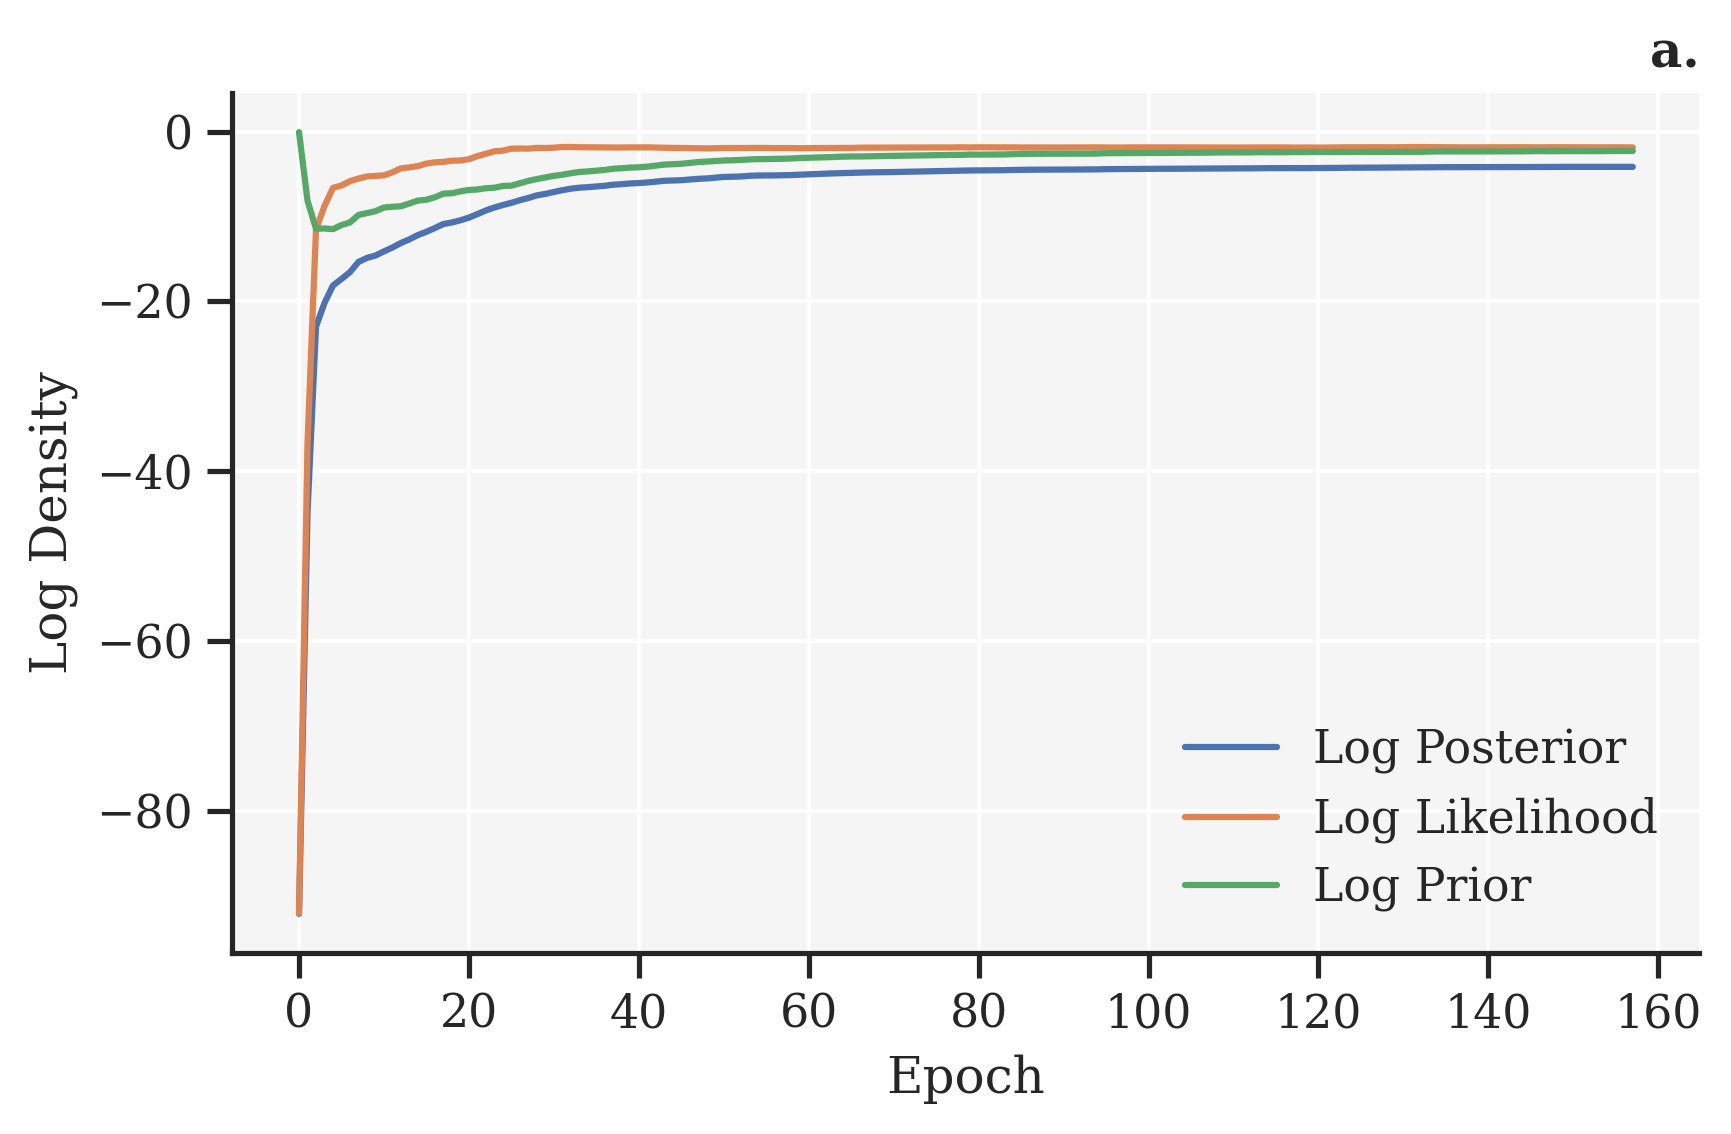

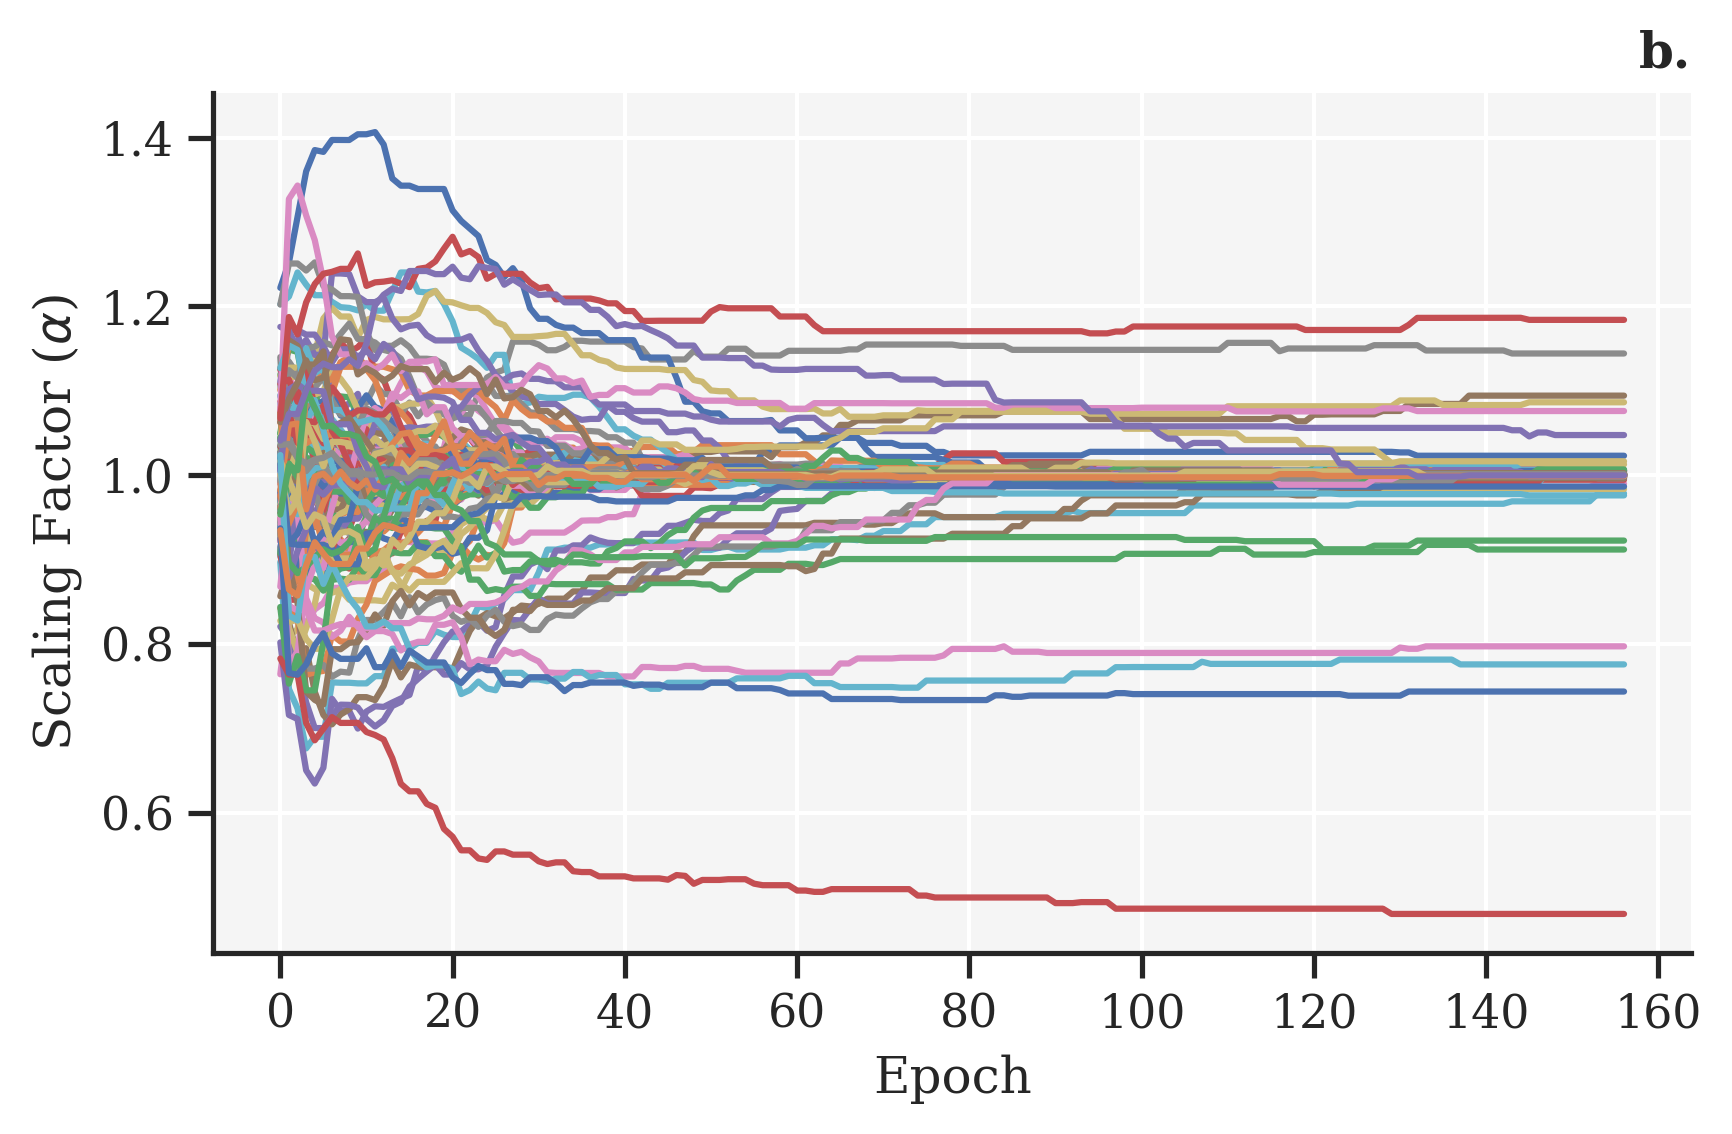

In [95]:
##################################
## VISUALISE CHAIN OPTIMISATION ##
##################################

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,4))
#
## Visualise posterior components
plt.plot(np.stack(lloss)[:,0], label='Log Posterior')
plt.plot(np.stack(lloss)[:,1], label='Log Likelihood')
plt.plot(np.stack(lloss)[:,2], label='Log Prior')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Log Density')
#
plt.grid(color='white')
plt.title('a.', fontweight='bold', loc='right')
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6,4))
#
## Visualise chain
plt.plot(np.stack(cchain)[:,1:])
plt.xlabel('Epoch')
plt.ylabel(fr"Scaling Factor ($\alpha$)")
#
plt.grid(color='white')
plt.title('b.', fontweight='bold', loc='right')
plt.tight_layout()
plt.show()
plt.close()
plt.rcParams['figure.dpi'] = 100

#
###

In [96]:
#############
## GET MAP ##
#############

## Plot fit
ttheta_map = get_map(chain)

#
###

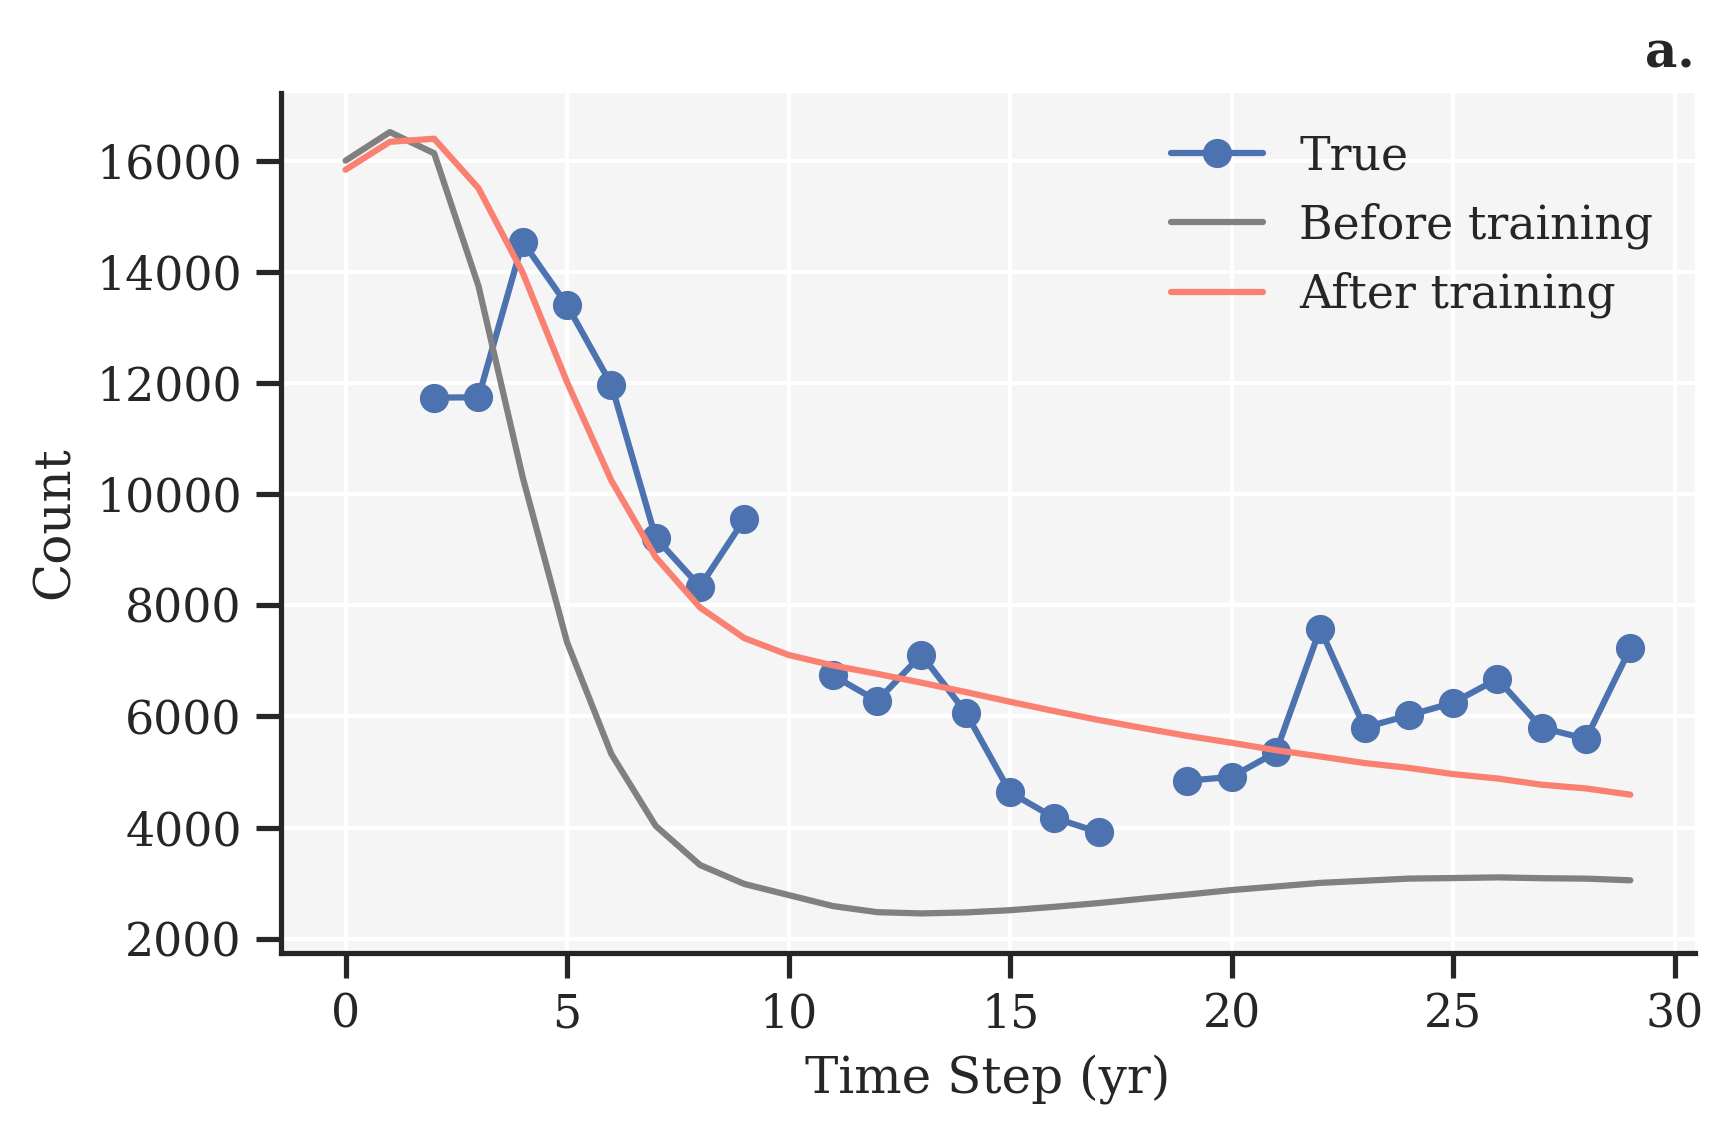

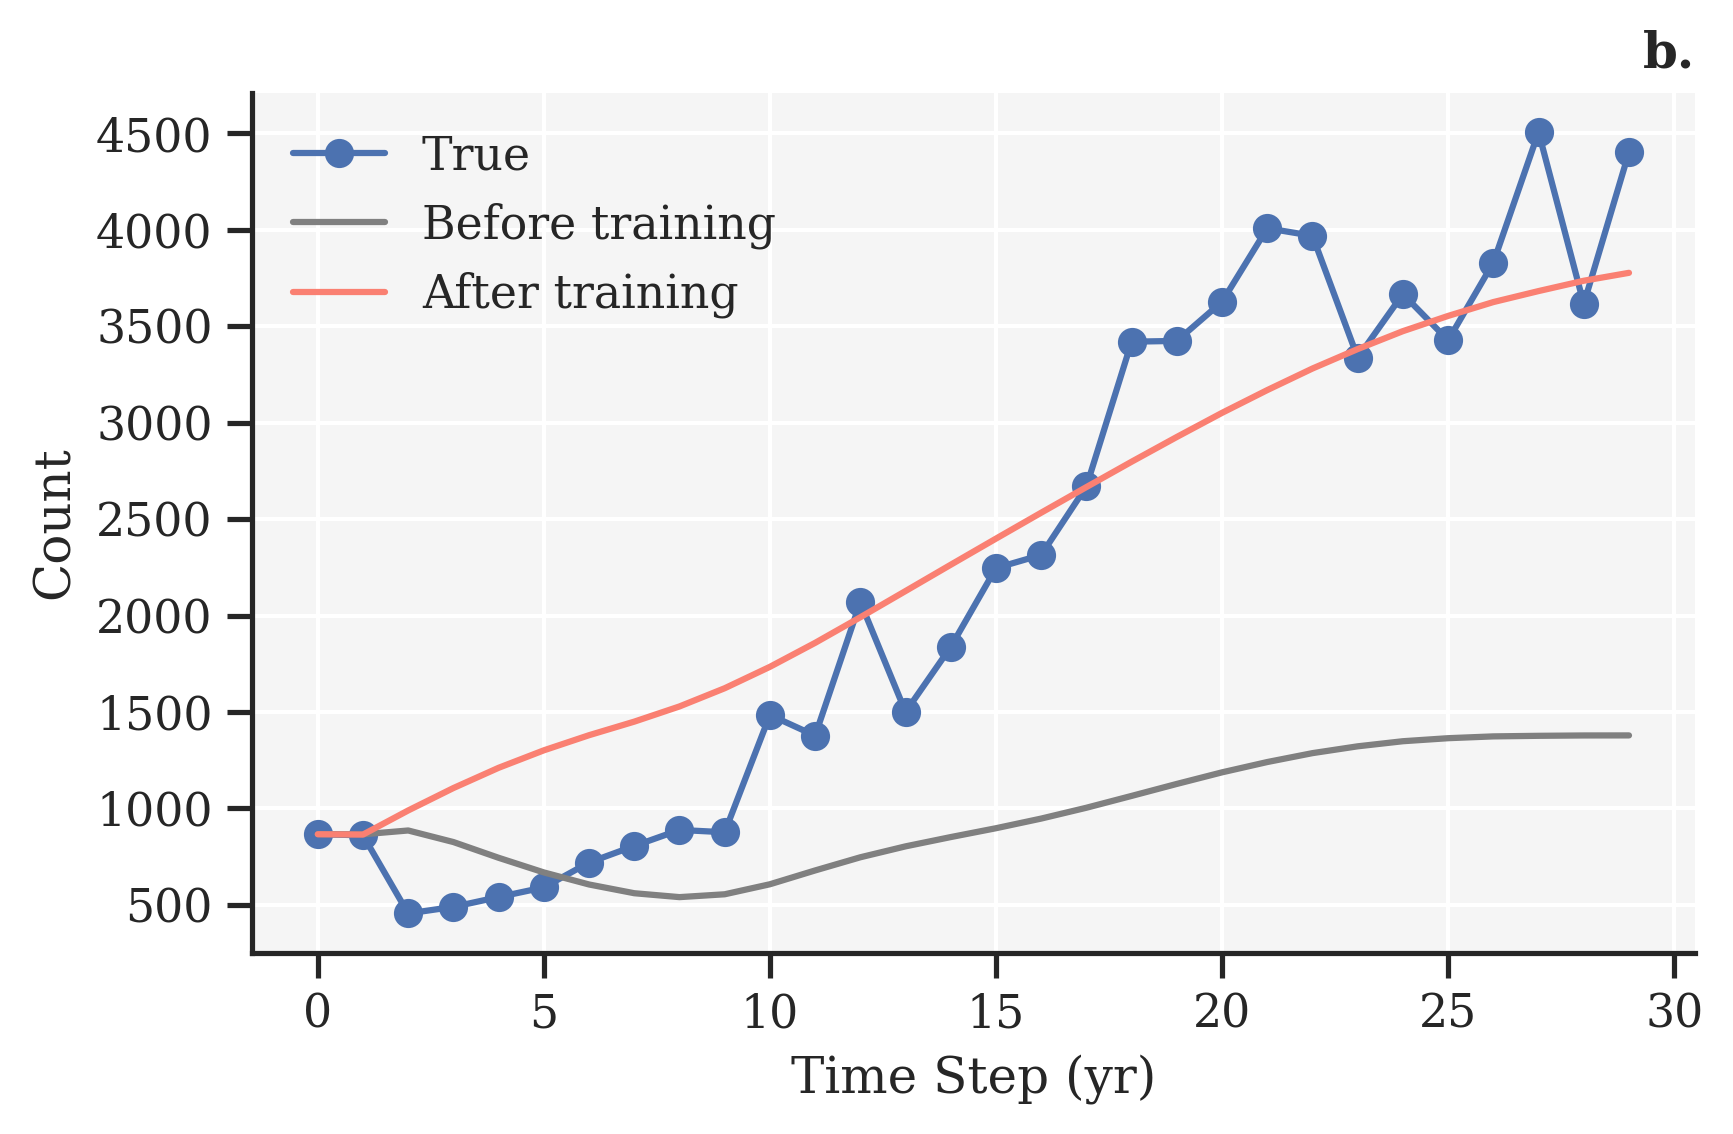

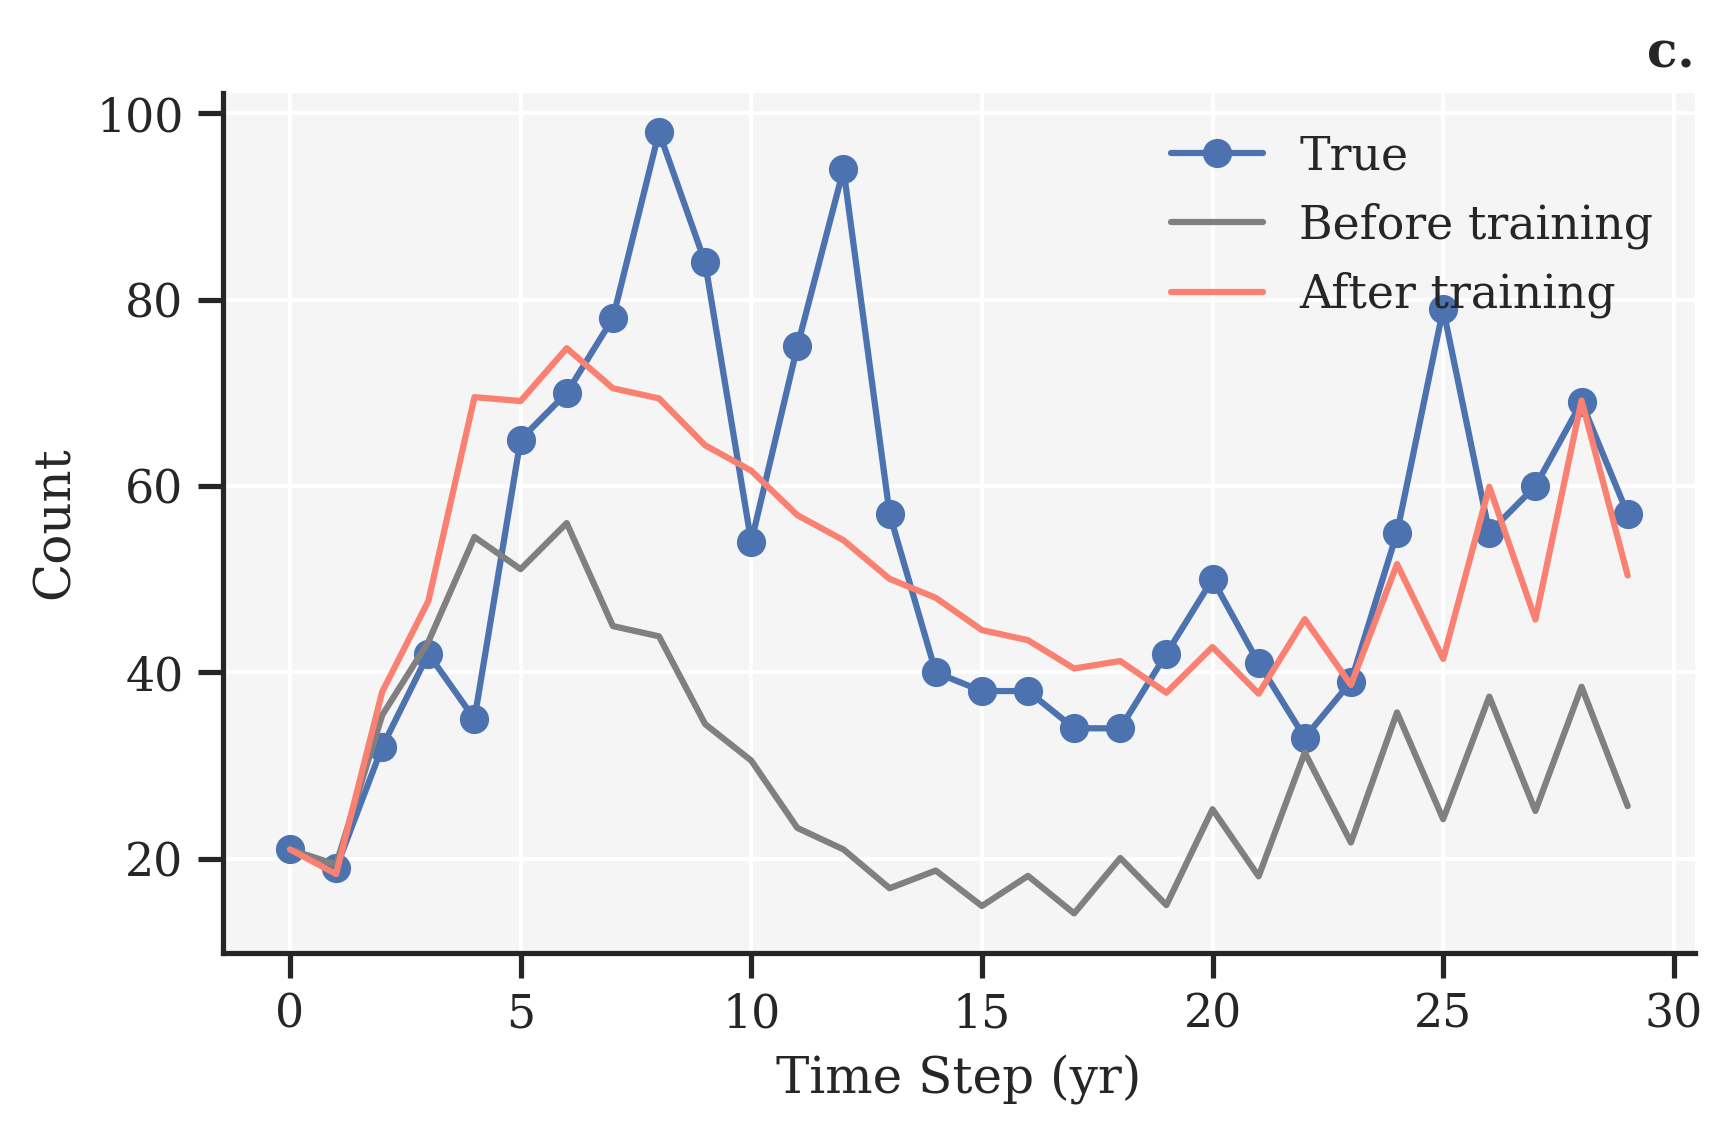

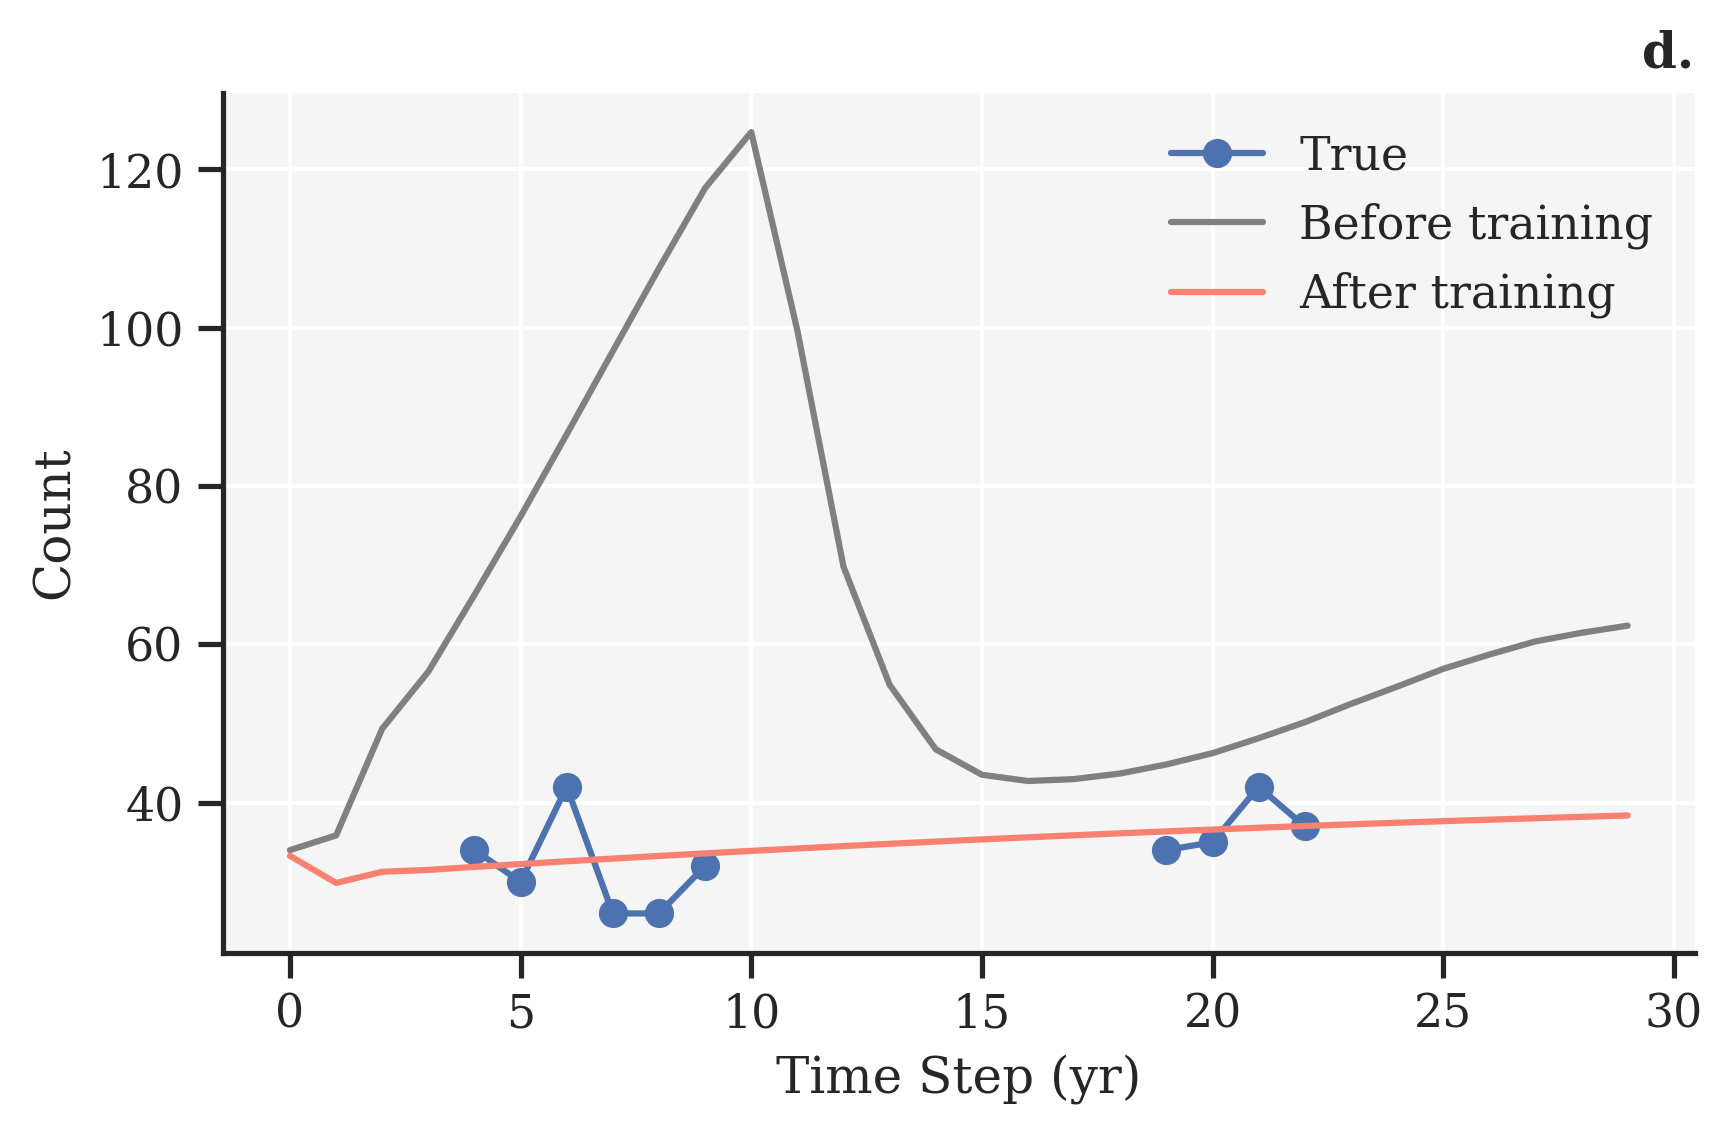

In [97]:
###########################
## VISUALISE FIT COMPACT ##
###########################

## Initial parameter vector
ttheta_0 = torch.ones(num_parameters)

## Predict
predictions_0 = wrapper(ttheta_0)
predictions_map = wrapper(ttheta_map)

## Format and standardize
pred_0 = format_predicted_time_series(predictions_0)
# pred_0 = apply_standardization(format_predicted_time_series(predictions_0), MEAN, STD)
pred_map = format_predicted_time_series(predictions_map)
# pred_map = apply_standardization(format_predicted_time_series(predictions_map), MEAN, STD)
true = time_series_tensor

## Figure
plt.rcParams['figure.dpi'] = 300
llabels = ['a.', 'b.', 'c.', 'd.']
k = 0
for i in [0, 1, 2, 3]:
    plt.figure(figsize=(6, 4))    
    plt.plot(true[:, i], 'o-', label='True')
    plt.plot(pred_0[:, i], label='Before training', color='grey')
    plt.plot(pred_map[:, i], label='After training', color='salmon')
    plt.xlabel('Time Step (yr)')
    plt.ylabel('Count')    
    plt.legend(frameon=False, fontsize=11)
    plt.title(llabels[k], loc='right', fontweight='bold')
    plt.grid(color='white')
    plt.tight_layout()
    plt.show()
    k += 1
plt.rcParams['figure.dpi'] = 100

#
###

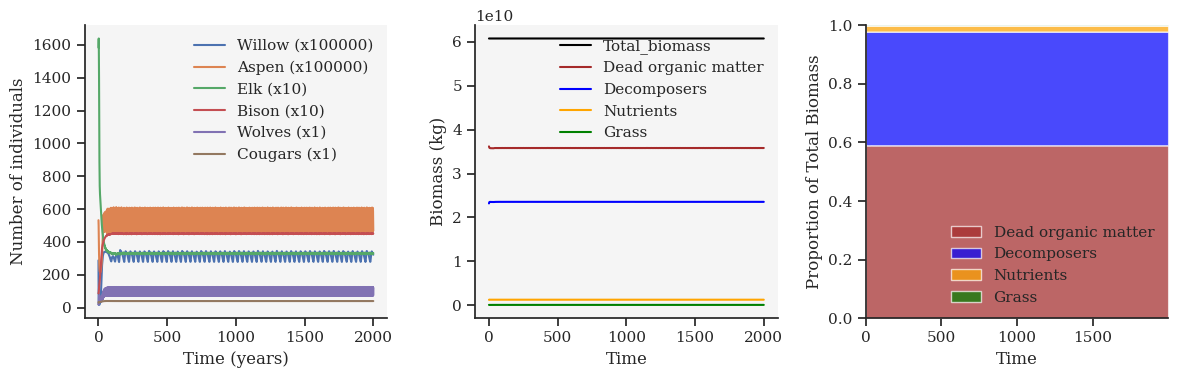

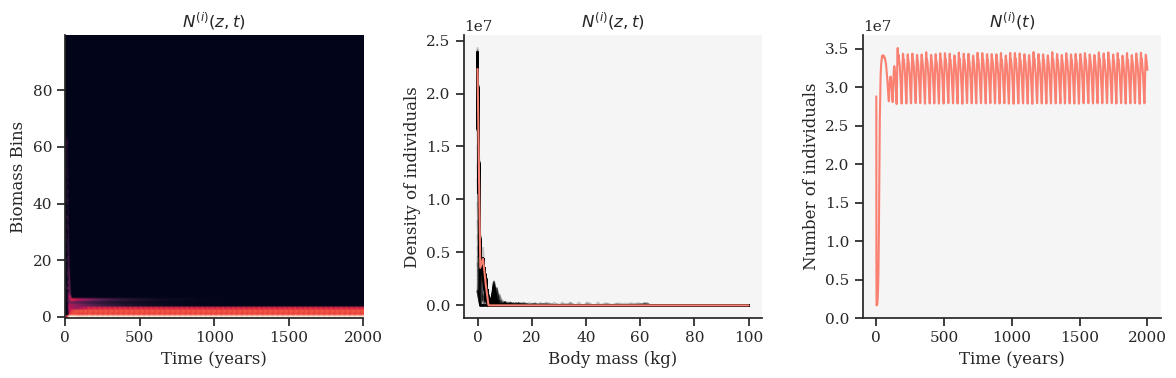

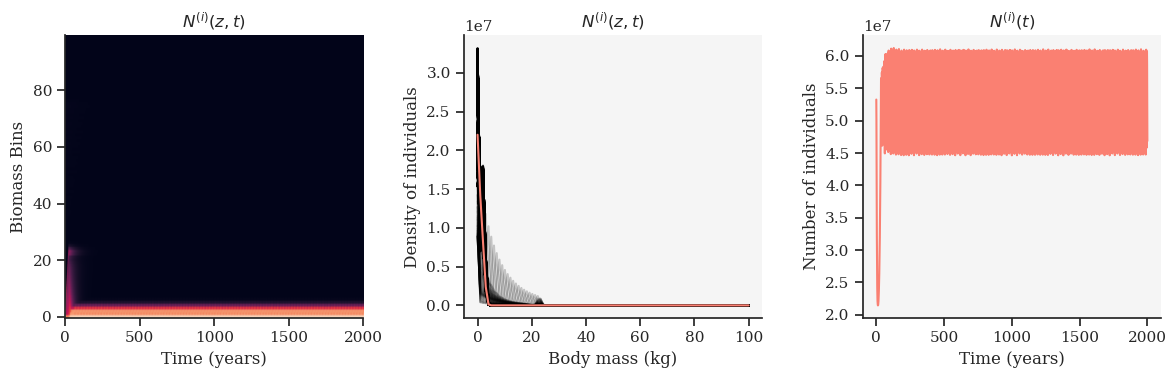

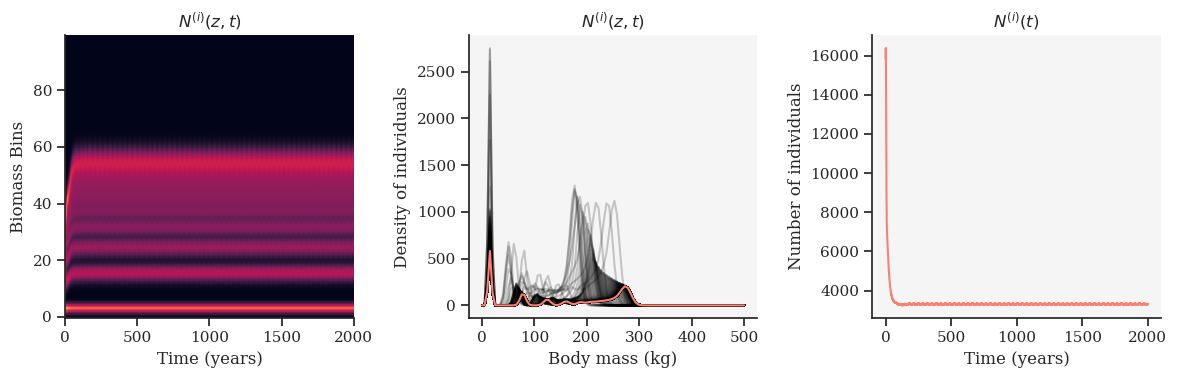

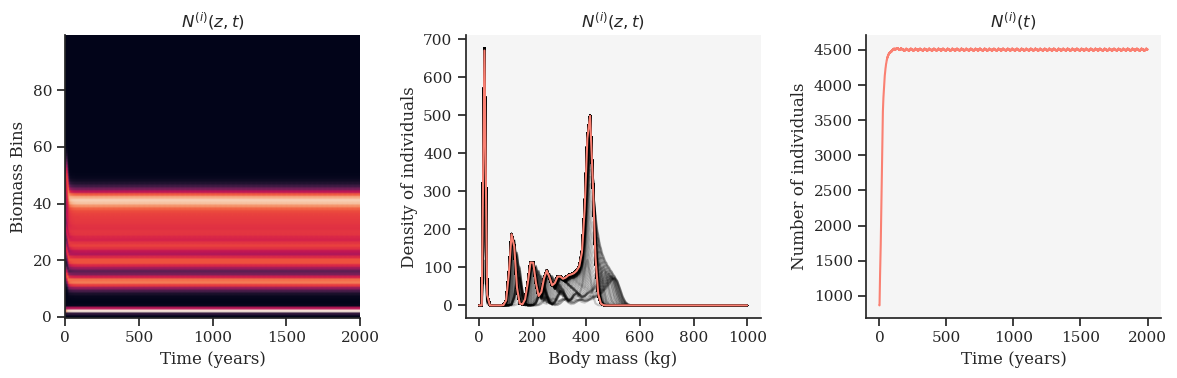

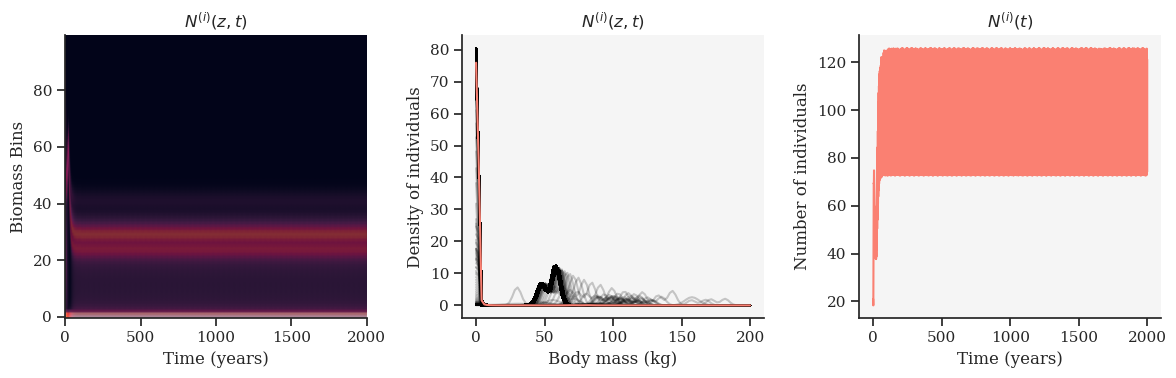

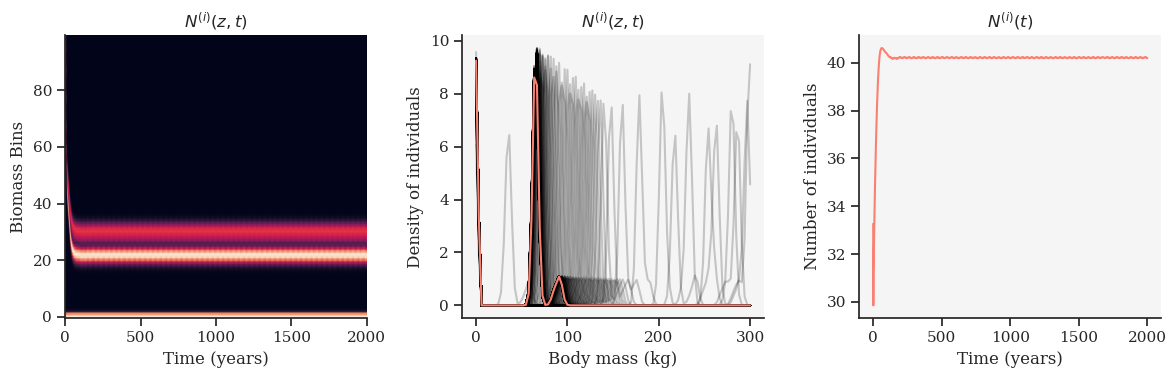

In [98]:
###############
## RUN MODEL ##
###############

## Visualise
ttheta_map = get_map(chain)
predictions_map = wrapper(ttheta_map, t_max=2000)
plot_model(predictions_map)

#
###